# Gambler Learning to Stop before Ruin


In [3]:
#------------------------------------------------------------------------------
# Dependencies:
import sys
import matplotlib.pyplot as plt
from math import factorial
from scipy.stats import beta as beta_dist
from scipy.special import binom
from scipy.special import beta as beta_func
from scipy.special import betainc as reg_inc_beta_func
from scipy.special import gamma as gamma_func
from scipy.integrate import quad as integral
#from scipy.integrate import fixed_quad as integral
#from scipy.integrate import quadrature as integral
#from mpmath import hyp2f1 as hypergeo_func
import numpy as np
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm
%matplotlib inline
import networkx as nx

#verify if notebook is running from google colab
COLAB = 'google.colab' in sys.modules

if COLAB:
    from google.colab import files

#------------------------------------------------------------------------------
#incomplete beta function
inc_beta_func = lambda alpha, beta, p_sup : reg_inc_beta_func(alpha, beta, p_sup) * beta_func(alpha, beta)

#------------------------------------------------------------------------------
#eta funcion (normalizing constant for beta pdf with uniform prior)
eta_func = lambda x, y : (x+y+1) * binom(x+y, x)    #stable and quick

#------------------------------------------------------------------------------
# - probability of winning : conditional prob function P(win | p, b, g)
#win_prob  = lambda p, b, g : (1.-((1.-p)/p)**b) / (1.-((1.-p)/p)**g) if (p!=0.5)  else  b/g
def win_prob(p, b, g):
  if (p == 0):
    return 0
  elif (p == 1):
    return 1
  elif (p == 0.5):
    return b/g
  else:
    return (1.-((1.-p)/p)**b) / (1.-((1.-p)/p)**g)

# - cumulative probability of winning
win_cumu  = lambda p_sup, b, g, p_inf=0 : integral(win_prob, p_inf, p_sup, (b, g), points=[0, 0.5, 1])[0]
#win_cumu  = lambda p_sup, b, g : integral(lambda p, b, g : (1-((1.-p)/p)**b) / (1-((1.-p)/p)**g)  if (p!=0.5)  else  b/g, 0, p_sup, (b, g))[0]
#win_cumu  = lambda p, b, g : integral(win_prob, 0, p, (b, g))[0] if p < 0.5 else integral(win_prob, 0, 0.5, (b, g))[0] + integral(win_prob, 0.5, p, (b, g))[0]

win_area  = lambda b, g : win_cumu(1, b, g)

#------------------------------------------------------------------------------

# - true mean estimation (or bayesian mode)
beta_post_mode = estimated_p_freq = posit_freq_prob = lambda k, z, prior_p=0.5 : k / (k+z) if (k+z) > 0 else prior_p

# - bayesian mean estimation
beta_post_mean = estimated_p_bayes = lambda k, z, prior_k=1, prior_z=1 : (k+prior_k)/(k+z+prior_k+prior_z)
#beta_post_mean = estimated_p_bayes = lambda k, z, prior_k=1, prior_z=1 : beta_dist.mean(k+prior_k, z+prior_z)

# - bayesian median estimation
beta_post_medi = lambda k, z, prior_k=1, prior_z=1 : beta_dist.median(k+prior_k, z+prior_z)

beta_post_pdf = lambda p, k, z : beta_dist.pdf(p, k+1, z+1)
beta_post_cdf = lambda p_sup, k, z : beta_dist.cdf(p_sup, k+1, z+1)

expected_r = lambda p : 2*p - 1

# - estimated probabilities of r using beta x expected_r
r_beta_prob = lambda p, k, z : expected_r(p) * beta_post_pdf(p, k, z)
# - cumulative estimated probability of winning using beta x win_prob
r_beta_cumu = lambda p_sup, k, z : integral(r_beta_prob, 0, p_sup, args=(k, z))[0]
# - total cumulative sum of estimated probability of winning using beta x win_prob
r_beta_area = lambda k, z : r_beta_cumu(1, k, z)
expected_beta_r = lambda k, z : beta_dist.expect(expected_r, args=(k+1, z+1), loc=0, scale=1, lb=0, ub=1, conditional=False)

#expected_beta_posit = lambda k, z : beta_dist.expect(args=(k+1, z+1), loc=0, scale=1, lb=0, ub=1, conditional=False)
expected_beta_posit = lambda k, z : beta_post_cdf(0.5, k, z)
expected_beta_negat = lambda k, z : 1 - expected_beta_posit

#------------------------------------------------------------------------------
# - estimated probability of winning using beta x win_prob
win_beta_prob = lambda p, k, z, b, g : win_prob(p, b, g) * beta_post_pdf(p, k, z)
# - cumulative estimated probability of winning using beta x win_prob
win_beta_cumu = lambda p_sup, k, z, b, g : integral(win_beta_prob, 0, p_sup, args=(k, z, b, g))[0]
# - total cumulative sum of estimated probability of winning using beta x win_prob
win_beta_area = lambda k, z, b, g : win_beta_cumu(1, k, z, b, g)
#expected_win_beta = lambda k, z, b, g : beta_dist.expect(win_prob, args=(k+1, z+1), loc=0, scale=1, lb=0, ub=1, conditional=False, args=(b, g))


#------------------------------------------------------------------------------
# - probability of ruin : conditional prob function P(ruin | p, b)
ruin_prob_inf  = lambda p, b : ((1.-p)**b / p**b)  if (p>0.5)  else  1.0             # = ((1-p)/p)**b
# - cumulative probability of ruin
#ruin_cumu =  lambda p_sup, b : integral(ruin_prob, 0.5, p_sup, (b))[0]
ruin_cumu  =  lambda p_sup, b : 0.5 + integral(lambda p, b : (1.-p)**b/p**b, 0.5, p_sup, (b))[0]  if (p_sup>0.5) else  p_sup
# - total cumulative sum of estimated probability of ruin using beta x ruin_prob
ruin_area  =  lambda b : ruin_cumu(1., b)
# - extended probability of ruin (extrapolated out of bounds)
ruin_func  = lambda p, b : ((1.-p)**b / p**b)  if (p>0)  else  float('+inf')   # = ((1-p)/p)**b
# - ruin inverse factor
#ruin_fact = lambda p, b : 1 / (1 + ruin_func(p,b))
ruin_fact  = lambda p, b : (p**b) / (p**b + (1.-p)**b)
# - ruin cumulative inverse factor
ruin_cufa = lambda p, b : integral(ruin_fact, 0., p, (b))[0]

#------------------------------------------------------------------------------
# - estimated time-horizon = E(tau | p, b)
tau_estm  =  lambda p, b : (b / (1. - 2.*p))  if  (p < 0.5)   else  float('inf')   # = (b / (q - p))
# - function time-horizon (extrapolated out of bounds)
tau_func =  lambda p, b : (b / (1. - 2.*p))  if  (p != 0.5)  else  float('inf')   # = (b / (q - p))
# - tau inverse factor
#tau_fact     = lambda p, b : (1 - 2*p) / b
#tau_fact =  lambda p, b : ((1 - 2*p) / b)  if  (b > 0)     else  float('inf')   # = (1 / (b / (q - p)))  =  ((q - p) / b)
tau_fact     = lambda p, b : (b + 2.*p - 1.) / (2.*b)   # = 1 - ((((1 - 2*p) / b) + 1) / 2)
# - tau cumulative inverse factor
#tau_cufa = lambda p, b : (p - p**2) / b  # = integral(tau_fact, 0, p, (b))[0]
# - transformed tau inverse factor for PDF
tau_pdf = lambda p, b : (((1. - 2.*p) / b) + 1)
# - transformed tau inverse factor CDF
tau_cdf = lambda p, b : (b*p - p**2. + p) / b  # = integral(tau_fact_pdf, 0, p, (b))[0]
#
#x_factor         = lambda p, b : (((2*p - 1) / b) + 1) / 2
#x_factor_pdf     = lambda p, b : (((2*p - 1) / b) + 1)

#------------------------------------------------------------------------------
# - estimated probability of ruin using beta x ruin_prob
#ruin_beta_prob = lambda p, k, z, b : ruin_prob(p, b) * beta_post_pdf(p, k, z)
ruin_beta_prob = lambda p, k, z, b : (1 / beta_func(k+1, z+1)) * p**k * (1-p)**z * ((1-p)/p)**b  if  (p > 0.5)  else  (1 / beta_func(k+1, z+1)) * p**k * (1-p)**z
# - cumulative estimated probability of ruin using beta x ruin_prob
ruin_beta_cumu = lambda p, k, z, b : integral(ruin_beta_prob, 0, p, (k, z, b))[0]
# - total cumulative sum of estimated probability of ruin using beta x ruin_prob
ruin_beta_area = lambda k, z, b : ruin_beta_cumu(1, k, z, b)

#------------------------------------------------------------------------------
# - estimated probability of ruin using beta x ruin_func
ruin_beta_func = lambda p, k, z, b : ruin_func(p, b) * beta_post_pdf(p, k, z)
# - cumulative estimated probability of ruin using beta x ruin_func
ruin_beta_cufu = lambda p, k, z, b : integral(ruin_beta_func, 0, p, (k, z, b))[0]
# - total cumulative sum of estimated probability of ruin using beta x ruin_func
ruin_beta_arfu = lambda k, z, b : ruin_beta_cufu(1, k, z, b)

#------------------------------------------------------------------------------
# - estimated probability of ruin using beta x ruin_fact
ruin_beta_fact = lambda p, k, z, b : ruin_fact(p, b) * beta_post_pdf(p, k, z)
# - cumulative estimated probability of ruin using beta x ruin_fact
ruin_beta_cufa = lambda p, k, z, b : integral(ruin_beta_fact, 0, p, (k, z, b))[0]
# - total cumulative sum of estimated probability of ruin using beta x ruin_fact
ruin_beta_arfa = lambda k, z, b : ruin_beta_cufa(1, k, z, b)

#------------------------------------------------------------------------------
# - estimated tau using beta x tau_fact
tau_beta_fact = lambda p, k, z, b : tau_fact(p, b) * beta_post_pdf(p, k, z)
# - cumulative estimated probability of ruin using beta x ruin_fact
tau_beta_cufa = lambda p, k, z, b : integral(tau_beta_fact, 0, p, (k, z, b))[0]
# - total cumulative sum of estimated probability of ruin using beta x ruin_fact
tau_beta_arfa = lambda k, z, b : tau_beta_cufa(1, k, z, b)

#ruin_est_func_for_total = lambda p, x, y, b : (1 / beta_func(x+1, y+1)) * p**x * (1-p)**y * ((1-p)/p)**b
#ruin_est_func_for_total = lambda p, x, y, b : ((1-p)/p)**b * beta.pdf(p, x+1, y+1)
#ruin_total_est_func = lambda x, y, b : beta_dist.cdf(0.5, x+1, y+1) + integral(ruin_est_func_for_total, 0.5, 1.0, (x, y, b))[0]
#ruin_total_est_func = lambda x, y, b : beta_dist.cdf(0.5, x+1, y+1) + integral(lambda p, x, y, b : ((1-p)/p)**b * beta_dist.pdf(p, x+1, y+1), 0.5, 1.0, (x, y, b))[0]

#------------------------------------------------------------------------------
#estimated tau factor
#x_est_factor_pdf     = lambda p, x, y, b : x_factor_pdf(p,b)  *  beta.pdf(p, x+1, y+1)
#x_est_factor_pdf     = lambda p, x, y, b : (((2*p - 1) / b) + 1)  *  (1 / beta_func(x+1, y+1)) * p**x * (1-p)**y
#x_est_factor_cdf     = lambda p, x, y, b : integral(x_est_factor_pdf, 0, p, (x,y,b))[0]

#surv_est_factor_pdf = lambda p, x, y, b : surv_factor(p,b)  *  beta.pdf(p, x+1, y+1)
#surv_est_factor_pdf = lambda p, x, y, b : integral(surv_factor, 0, p, (b))[0]
#surv_est_factor_cdf = lambda p, x, y, b : integral(surv_est_factor_pdf, 0, p, (x,y,b))[0]

loss_prob = lambda p : 1. - p  #  = q
#loss_beta_area = lambda x, y : beta_dist.expect(loss_prob, (x+1, y+1))
loss_beta_area = lambda k, z : 1. - beta_post_mean(k, z)



In [4]:
k=10
z=13
n=k+z
b=14
g=17
print(k/n)
print(win_prob(k/n, b, g))
print((k+1)/(n+2))
print(win_prob((k+1)/(n+2), b, g))
print(win_beta_area(k,z,b,g))

0.43478260869565216
0.4487941197107215
0.44
0.47637837112895165
0.514275251333394


Calculate:

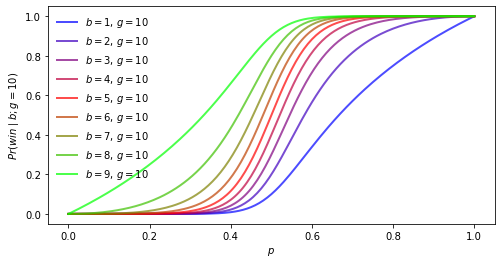

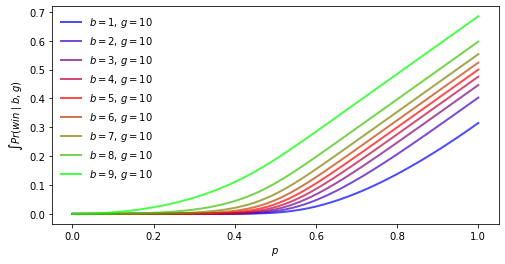

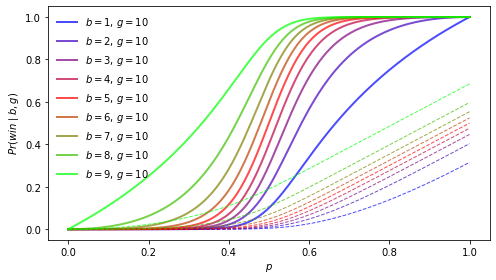

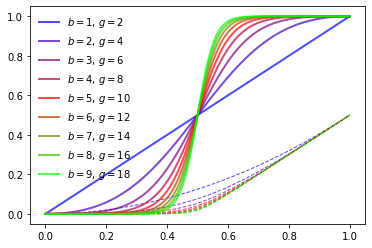

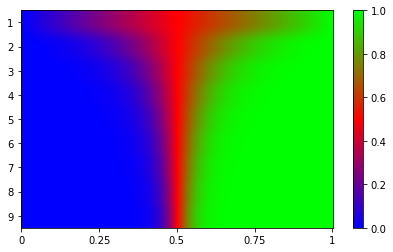

In [5]:
#samples for p
arr_p_size = 201

arr_p = np.linspace(0, 1, arr_p_size)
arr_q = 1 - arr_p

# b is the budget
arr_b = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
g = 10

#number of cases
arr_b_size = len(arr_b)

#win_prob given budget
win_prob_b = np.zeros((arr_b_size, arr_p_size))
win_cumu_b = np.zeros((arr_b_size, arr_p_size))

for idx_b in range(arr_b_size):
    for idx_p in range(arr_p_size):
        win_prob_b[idx_b][idx_p] = win_prob(arr_p[idx_p], arr_b[idx_b], g)
        win_cumu_b[idx_b][idx_p] = win_cumu(arr_p[idx_p], arr_b[idx_b], g)

arr_color_idx = np.linspace(0, 1, arr_b_size)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
for idx_b in range(arr_b_size):
  plt.plot(arr_p, win_prob_b[idx_b] , color=plt.cm.brg(arr_color_idx[idx_b]), lw=2, alpha=0.7, label='$b=' + str(arr_b[idx_b]) + '$, $g=10$')
plt.legend(loc='best', frameon=False)
ax.set_xlabel("$p$")
ax.set_ylabel("$Pr(win \mid b; g=10)$")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
for idx_b in range(arr_b_size):
    plt.plot(arr_p, win_cumu_b[idx_b] , color=plt.cm.brg(arr_color_idx[idx_b]), lw=2, alpha=0.7, label='$b=' + str(arr_b[idx_b]) + '$, $g=10$')
plt.legend(loc='best', frameon=False)
ax.set_xlabel("$p$")
ax.set_ylabel("$\int Pr(win \mid b, g)$")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(7, 4))
for idx_b in range(arr_b_size):
  plt.plot(arr_p, win_prob_b[idx_b] , color=plt.cm.brg(arr_color_idx[idx_b]), lw=2, alpha=0.7, label='$b=' + str(arr_b[idx_b]) + '$, $g=10$')
  plt.plot(arr_p, win_cumu_b[idx_b] , color=plt.cm.brg(arr_color_idx[idx_b]), linestyle='--', lw=1, alpha=0.7)
plt.legend(loc='best', frameon=False)
ax.set_xlabel("$p$")
ax.set_ylabel("$Pr(win \mid b, g)$")
fig.tight_layout()
plt.savefig('win_prob_p.pdf', bbox_inches='tight')
#files.download('.pdf')
plt.show()

# g is the total fortune
arr_g = np.array([2, 4, 6, 8, 10, 12, 14, 16, 18])
arr_g_size = len(arr_g)

win_prob_g = np.zeros((arr_g_size, arr_p_size))
win_cumu_g = np.zeros((arr_g_size, arr_p_size))

for idx_g in range(arr_g_size):
    for idx_p in range(arr_p_size):
        win_prob_g[idx_g][idx_p] = win_prob(arr_p[idx_p], arr_g[idx_g] // 2, arr_g[idx_g])
        win_cumu_g[idx_g][idx_p] = win_cumu(arr_p[idx_p], arr_g[idx_g] // 2, arr_g[idx_g])

arr_color_idx = np.linspace(0, 1, arr_g_size)

for idx_g in range(arr_g_size):
    plt.plot(arr_p, win_prob_g[idx_g] , color=plt.cm.brg(arr_color_idx[idx_g]), lw=2, alpha=0.7, label='$b=' + str(arr_g[idx_g]//2) + '$, $g=' + str(arr_g[idx_g]) + '$')
    plt.plot(arr_p, win_cumu_g[idx_g] , color=plt.cm.brg(arr_color_idx[idx_g]), linestyle='--', lw=1, alpha=0.7)
plt.legend(loc='best', frameon=False)
ax.set_xlabel("$p$")
ax.set_ylabel("$Pr(win \mid b, g)$")
fig.tight_layout()
plt.savefig('win_prob_g.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.set_xticks([0,50,100,150,200])
ax.set_yticks(range(arr_b_size))
ax.set_xticklabels([0, 0.25, 0.5, 0.75, 1])
ax.set_yticklabels(arr_b)
plt.imshow(win_prob_g, cmap='brg', aspect='auto')
plt.colorbar()
plt.show()



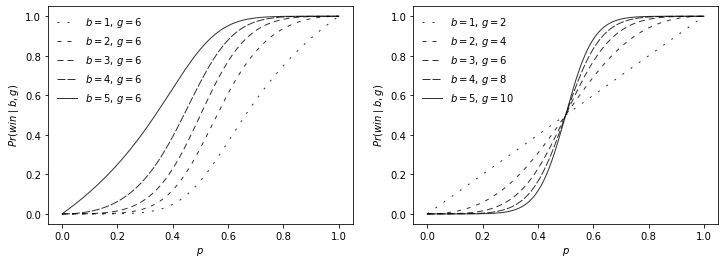

In [7]:
#samples for p
arr_p_size = 201

arr_p = np.linspace(0, 1, arr_p_size)
arr_q = 1 - arr_p

# b is the budget
arr_b = np.array([1, 2, 3, 4, 5])
g = 6

#number of cases
arr_b_size = len(arr_b)

#win_prob given budget
win_prob_b = np.zeros((arr_b_size, arr_p_size))
win_cumu_b = np.zeros((arr_b_size, arr_p_size))

for idx_b in range(arr_b_size):
    for idx_p in range(arr_p_size):
        win_prob_b[idx_b][idx_p] = win_prob(arr_p[idx_p], arr_b[idx_b], g)
        win_cumu_b[idx_b][idx_p] = win_cumu(arr_p[idx_p], arr_b[idx_b], g)

# g is the total fortune
arr_g = np.array([2, 4, 6, 8, 10])
arr_g_size = len(arr_g)

win_prob_g = np.zeros((arr_g_size, arr_p_size))
win_cumu_g = np.zeros((arr_g_size, arr_p_size))

for idx_g in range(arr_g_size):
    for idx_p in range(arr_p_size):
        win_prob_g[idx_g][idx_p] = win_prob(arr_p[idx_p], arr_g[idx_g] // 2, arr_g[idx_g])
        win_cumu_g[idx_g][idx_p] = win_cumu(arr_p[idx_p], arr_g[idx_g] // 2, arr_g[idx_g])

arr_color_idx = np.linspace(0, 1, arr_g_size)
arr_linestyle = [(0, (2, 8)), (0, (4, 6)), (0, (6, 4)), (0, (8, 2)), '-']

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for idx_b in range(arr_b_size):
    ax[0].plot(arr_p, win_prob_b[idx_b] , linestyle=arr_linestyle[idx_b], color='k', lw=1, alpha=0.8, label='$b=' + str(arr_b[idx_b]) + '$, $g=6$')
for idx_g in range(arr_g_size):
    ax[1].plot(arr_p, win_prob_g[idx_g] , linestyle=arr_linestyle[idx_g], color='k', lw=1, alpha=0.8, label='$b=' + str(arr_g[idx_g]//2) + '$, $g=' + str(arr_g[idx_g]) + '$')
ax[0].set_xlabel("$p$")
ax[0].set_ylabel("$Pr(win \mid b, g)$")
ax[0].legend(loc='best', frameon=False)
ax[1].set_xlabel("$p$")
ax[1].set_ylabel("$Pr(win \mid b, g)$")
ax[1].legend(loc='best', frameon=False)
plt.savefig('win_probs.pdf', bbox_inches='tight')

plt.show()

if COLAB:
    files.download('win_probs.pdf')



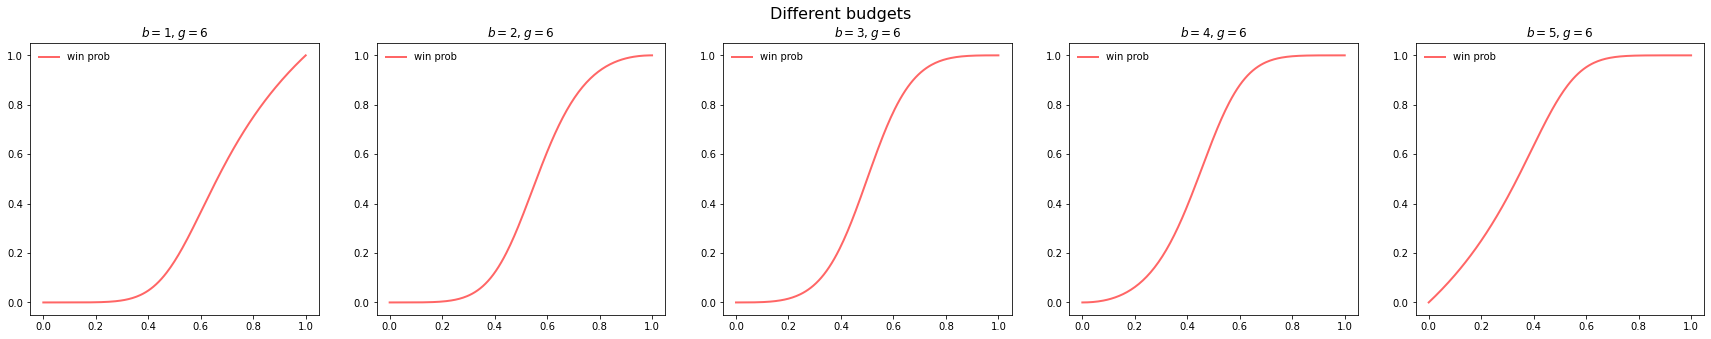

In [8]:
fig, ax = plt.subplots(1, arr_b_size, figsize=(30, 5))
fig.suptitle(f'Different budgets', fontsize=16)
for idx_b in range(arr_b_size):
    ax[idx_b].set_title(f'$b={arr_b[idx_b]}, g={g}$')
    ax[idx_b].plot(arr_p, win_prob_b[idx_b] , 'r-' , lw=2, alpha=0.6, label='win prob')
    ax[idx_b].legend(loc='best', frameon=False)
plt.show()

In [9]:
# b is the budget
arr_b = np.array([1, 9])
arr_b_size = 2

#number of cases
arr_n_size = 7

# k is the nuber of successes
arr_k = np.array([0, 1, 1, 2, 20, 1, 10])
# z is the nuber of fails
arr_z = np.array([0, 1, 2, 1, 1, 20, 10])

#alpha and beta parameters considering uniform prior
#arr_alpha = arr_k+1
#arr_beta = arr_z+1

arr_expected_r = expected_r(arr_p)

#win_prob given budget
win_prob_bp = np.zeros((arr_b_size,arr_p_size))
win_cumu_bp = np.zeros((arr_b_size,arr_p_size))
for idx_b in range(arr_b_size):
    for idx_p in range(arr_p_size):
        win_prob_bp[idx_b][idx_p] = win_prob(arr_p[idx_p], arr_b[idx_b], g)
        win_cumu_bp[idx_b][idx_p] = win_cumu(arr_p[idx_p], arr_b[idx_b], g)

#prepare 
beta_pdf_np = np.zeros((arr_n_size, arr_p_size))
beta_cdf_np = np.zeros((arr_n_size, arr_p_size))
beta_mean_n = np.zeros((arr_n_size))
beta_medi_n = np.zeros((arr_n_size))
beta_mode_n = np.zeros((arr_n_size))
win_beta_prob_nbp = np.zeros((arr_n_size, arr_b_size, arr_p_size))
win_beta_cumu_nbp = np.zeros((arr_n_size, arr_b_size, arr_p_size))
r_beta_prob_nbp = np.zeros((arr_n_size, arr_p_size))
r_beta_cumu_nbp = np.zeros((arr_n_size, arr_p_size))

for idx_n in range(arr_n_size):
    for idx_p in range(arr_p_size):
        r_beta_prob_nbp[idx_n][idx_p] = r_beta_prob(arr_p[idx_p], arr_k[idx_n], arr_z[idx_n])
        r_beta_cumu_nbp[idx_n][idx_p] = r_beta_cumu(arr_p[idx_p], arr_k[idx_n], arr_z[idx_n])
    for idx_b in range(arr_b_size):
        beta_pdf_np[idx_n] = beta_post_pdf(arr_p, arr_k[idx_n], arr_z[idx_n])  
        beta_cdf_np[idx_n] = beta_post_cdf(arr_p, arr_k[idx_n], arr_z[idx_n])  
        beta_mean_n[idx_n] = beta_post_mean(arr_k[idx_n], arr_z[idx_n])
        beta_medi_n[idx_n] = beta_post_medi(arr_k[idx_n], arr_z[idx_n])
        beta_mode_n[idx_n] = beta_post_mode(arr_k[idx_n], arr_z[idx_n])
        for idx_p in range(arr_p_size):
            win_beta_prob_nbp[idx_n][idx_b][idx_p] = win_beta_prob(arr_p[idx_p], arr_k[idx_n], arr_z[idx_n], arr_b[idx_b], g)
            win_beta_cumu_nbp[idx_n][idx_b][idx_p] = win_beta_cumu(arr_p[idx_p], arr_k[idx_n], arr_z[idx_n], arr_b[idx_b], g)


<ipython-input-3-a95c0de3da17>:49: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  win_cumu  = lambda p_sup, b, g, p_inf=0 : integral(win_prob, p_inf, p_sup, (b, g), points=[0, 0.5, 1])[0]
<ipython-input-3-a95c0de3da17>:49: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  win_cumu  = lambda p_sup, b, g, p_inf=0 : integral(win_prob, p_inf, p_sup, (b, g), points=[0, 0.5, 1])[0]
<ipython-input-3-a95c0de3da17>:88: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  win_beta_cumu = lambda p_sup, k, z, b, g : integral(win_beta_prob, 0, p_sup, args=(k, z, b, g))[0]
<ipython-input-3-a95c0de3da17>:88: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assu

<ipython-input-3-a95c0de3da17>:88: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  win_beta_cumu = lambda p_sup, k, z, b, g : integral(win_beta_prob, 0, p_sup, args=(k, z, b, g))[0]
<ipython-input-3-a95c0de3da17>:88: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  win_beta_cumu = lambda p_sup, k, z, b, g : integral(win_beta_prob, 0, p_sup, args=(k, z, b, g))[0]
<ipython-input-3-a95c0de3da17>:88: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  win_beta_cumu = lambda p_sup, k, z, b, g : integral(win_beta_prob, 0, p_sup, args=(k, z, b, g))[0]
<ipython-input-3-a95c0de3da17>:88: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  win_beta_cumu = lambda p_sup, k, z, b, g : integral(win_beta_prob, 0, p_sup, args=(k, z, b, g))[0]
<ipython-input-3-a95c0de3da17>:88: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yiel

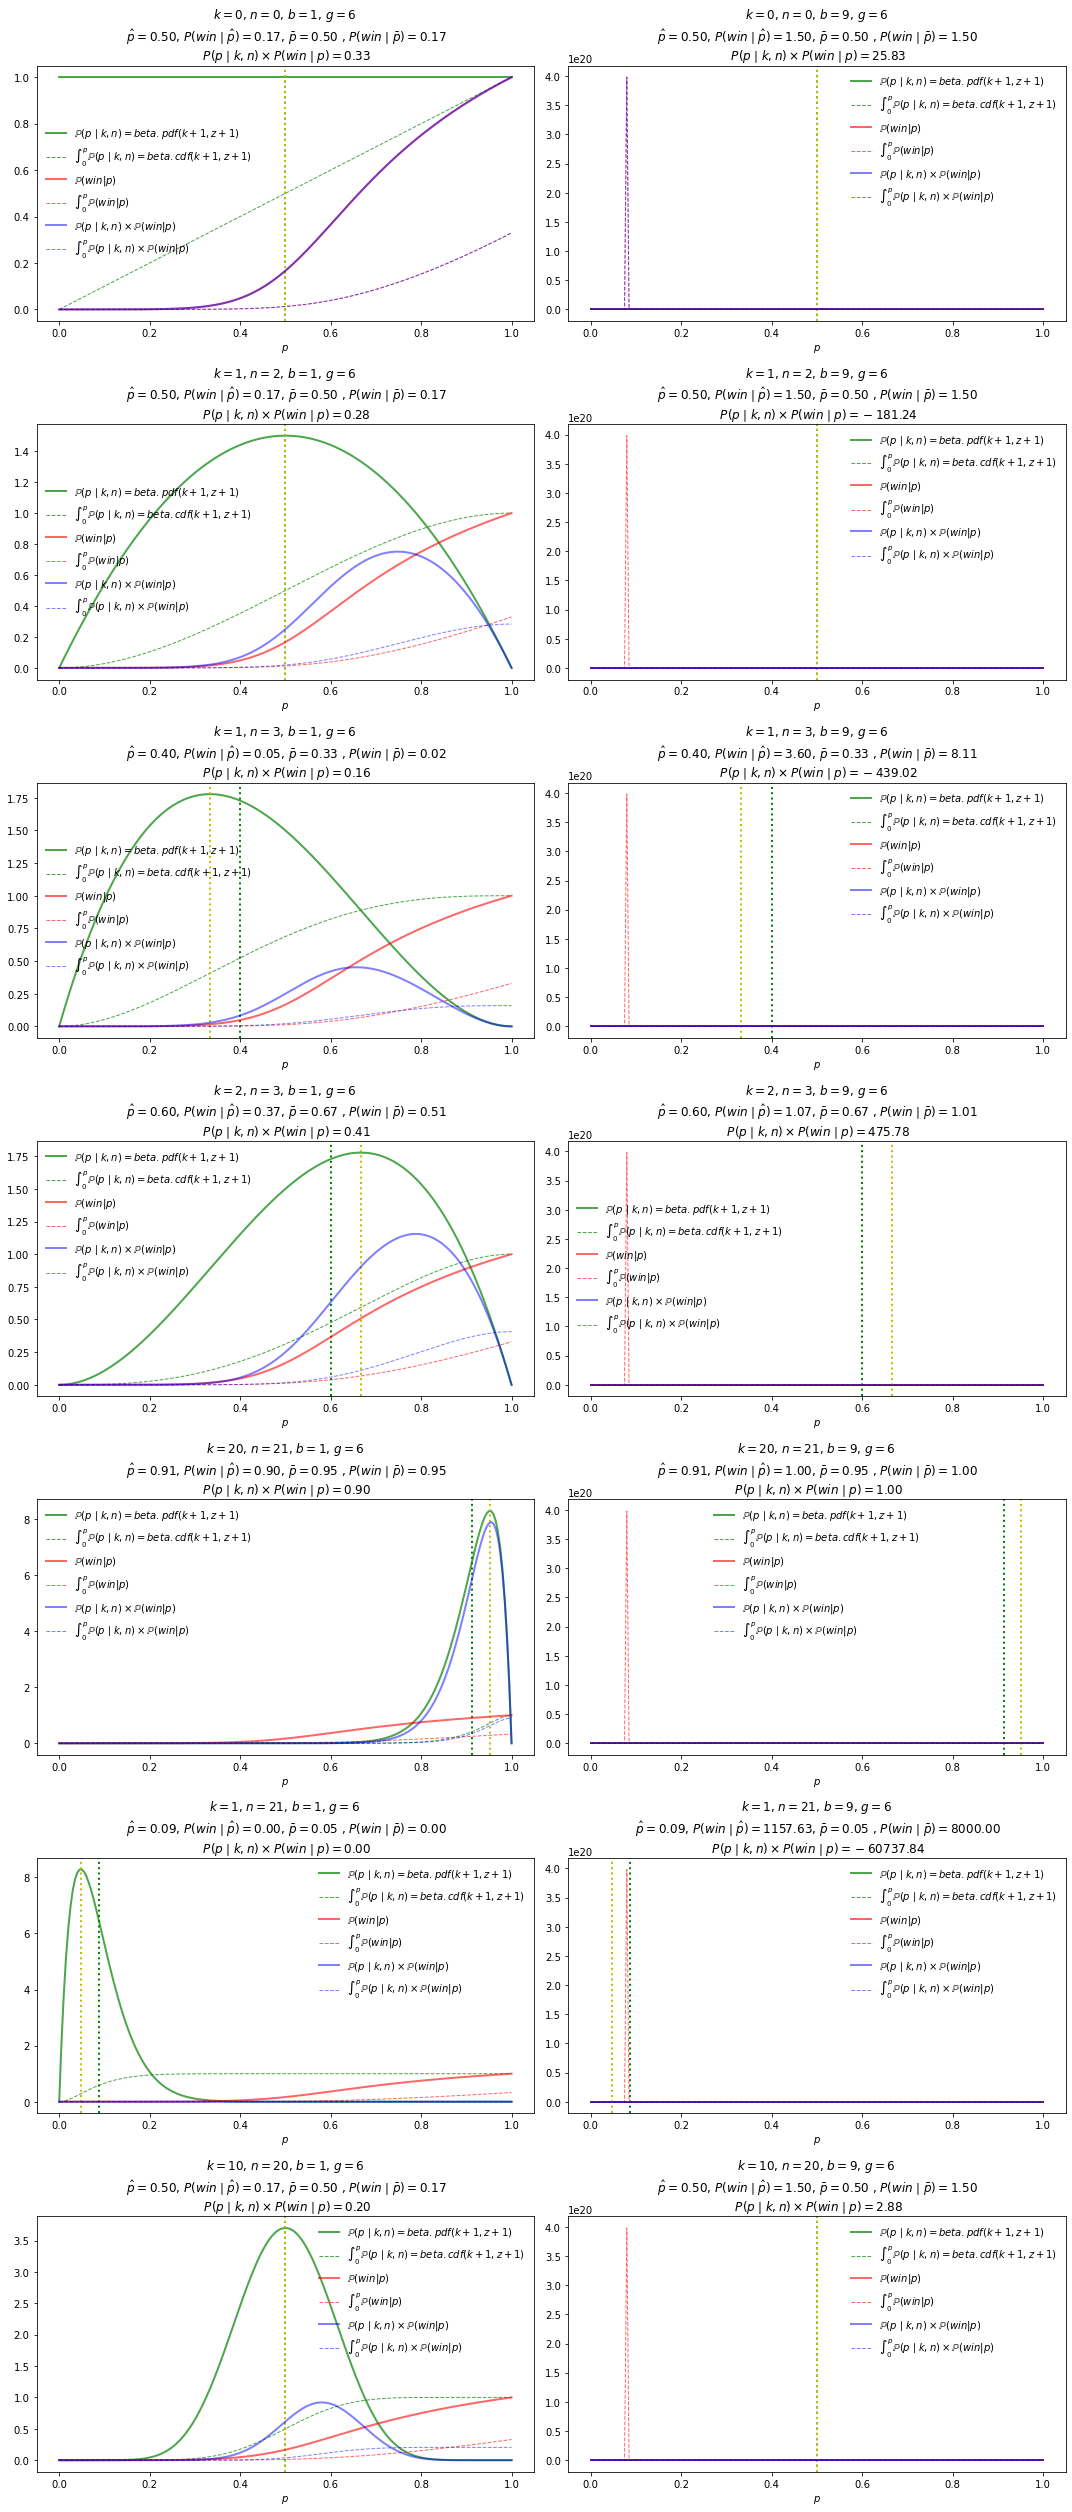

In [10]:
fig, ax = plt.subplots(arr_n_size, arr_b_size, figsize=(15, 35))
plt.subplots_adjust(hspace=0.5)

for idx_n in range(arr_n_size):
    k = arr_k[idx_n]
    z = arr_z[idx_n]
    phat = beta_mean_n[idx_n]
    pbar = beta_mode_n[idx_n]
    for idx_b in range(arr_b_size):
        b = arr_b[idx_b]
        pwhat = win_prob(phat, b, g)
        pwbar = win_prob(pbar, b, g)
        pw0 = win_prob(0.5, b, g)
        pwuni = win_beta_area(0, 0, b, g)
        pw = win_beta_area(k, z, b, g)
        #$P(win \\mid p=0.5) ={pw0:.2f}$, $P(win \mid U(p)) ={pwuni:.2f}$ \n
        ax[idx_n, idx_b].set_title(f'$k={k}$, $n={z+k}$, $b={b}$, $g={g}$ \n $\\hat p={phat:.2f}$, $P(win \\mid \\hat p)={pwhat:.2f}$, $\\bar p={pbar:.2f}$ , $P(win \\mid \\bar p)={pwbar:.2f}$ \n $P(p \mid k, n) \\times P(win \\mid p) = {pw:.2f}$')
        ax[idx_n, idx_b].plot(arr_p, beta_pdf_np[idx_n] , 'g-', lw=2, alpha=0.7, label=r'$\mathbb{P}(p \mid k, n) = beta.pdf(k+1, z+1)$')
        ax[idx_n, idx_b].plot(arr_p, beta_cdf_np[idx_n] , 'g--', lw=1, alpha=0.7, label=r'$\int_0^p \mathbb{P}(p \mid k, n) = beta.cdf(k+1, z+1)$')
        ax[idx_n, idx_b].axvline(x=beta_mean_n[idx_n], color='g', lw=2, linestyle=':')
        #ax[idx_n, idx_b].axvline(x=beta_medi_n[idx_n], color='m', lw=2, linestyle=':')
        ax[idx_n, idx_b].axvline(x=beta_mode_n[idx_n], color='y', lw=2, linestyle=':')
        ax[idx_n, idx_b].plot(arr_p, win_prob_bp[idx_b] , 'r-',  lw=2, alpha=0.6, label='$\mathbb{P}(win | p)$')
        ax[idx_n, idx_b].plot(arr_p, win_cumu_bp[idx_b] , 'r--', lw=1, alpha=0.6, label='$\int_0^p \mathbb{P}(win | p)$')
        ax[idx_n, idx_b].plot(arr_p, win_beta_prob_nbp[idx_n][idx_b] , 'b-' , lw=2, alpha=0.5, label='$\mathbb{P}(p \mid k, n) \\times \mathbb{P}(win | p) $')
        ax[idx_n, idx_b].plot(arr_p, win_beta_cumu_nbp[idx_n][idx_b] , 'b--', lw=1, alpha=0.5, label='$\int_0^p \mathbb{P}(p \mid k, n) \\times \mathbb{P}(win | p) $')
        ax[idx_n, idx_b].set_xlabel('$p$')
        ax[idx_n, idx_b].legend(loc='best', frameon=False)

fig.tight_layout()

plt.savefig('beta_win_examples.pdf', bbox_inches='tight')

plt.show()

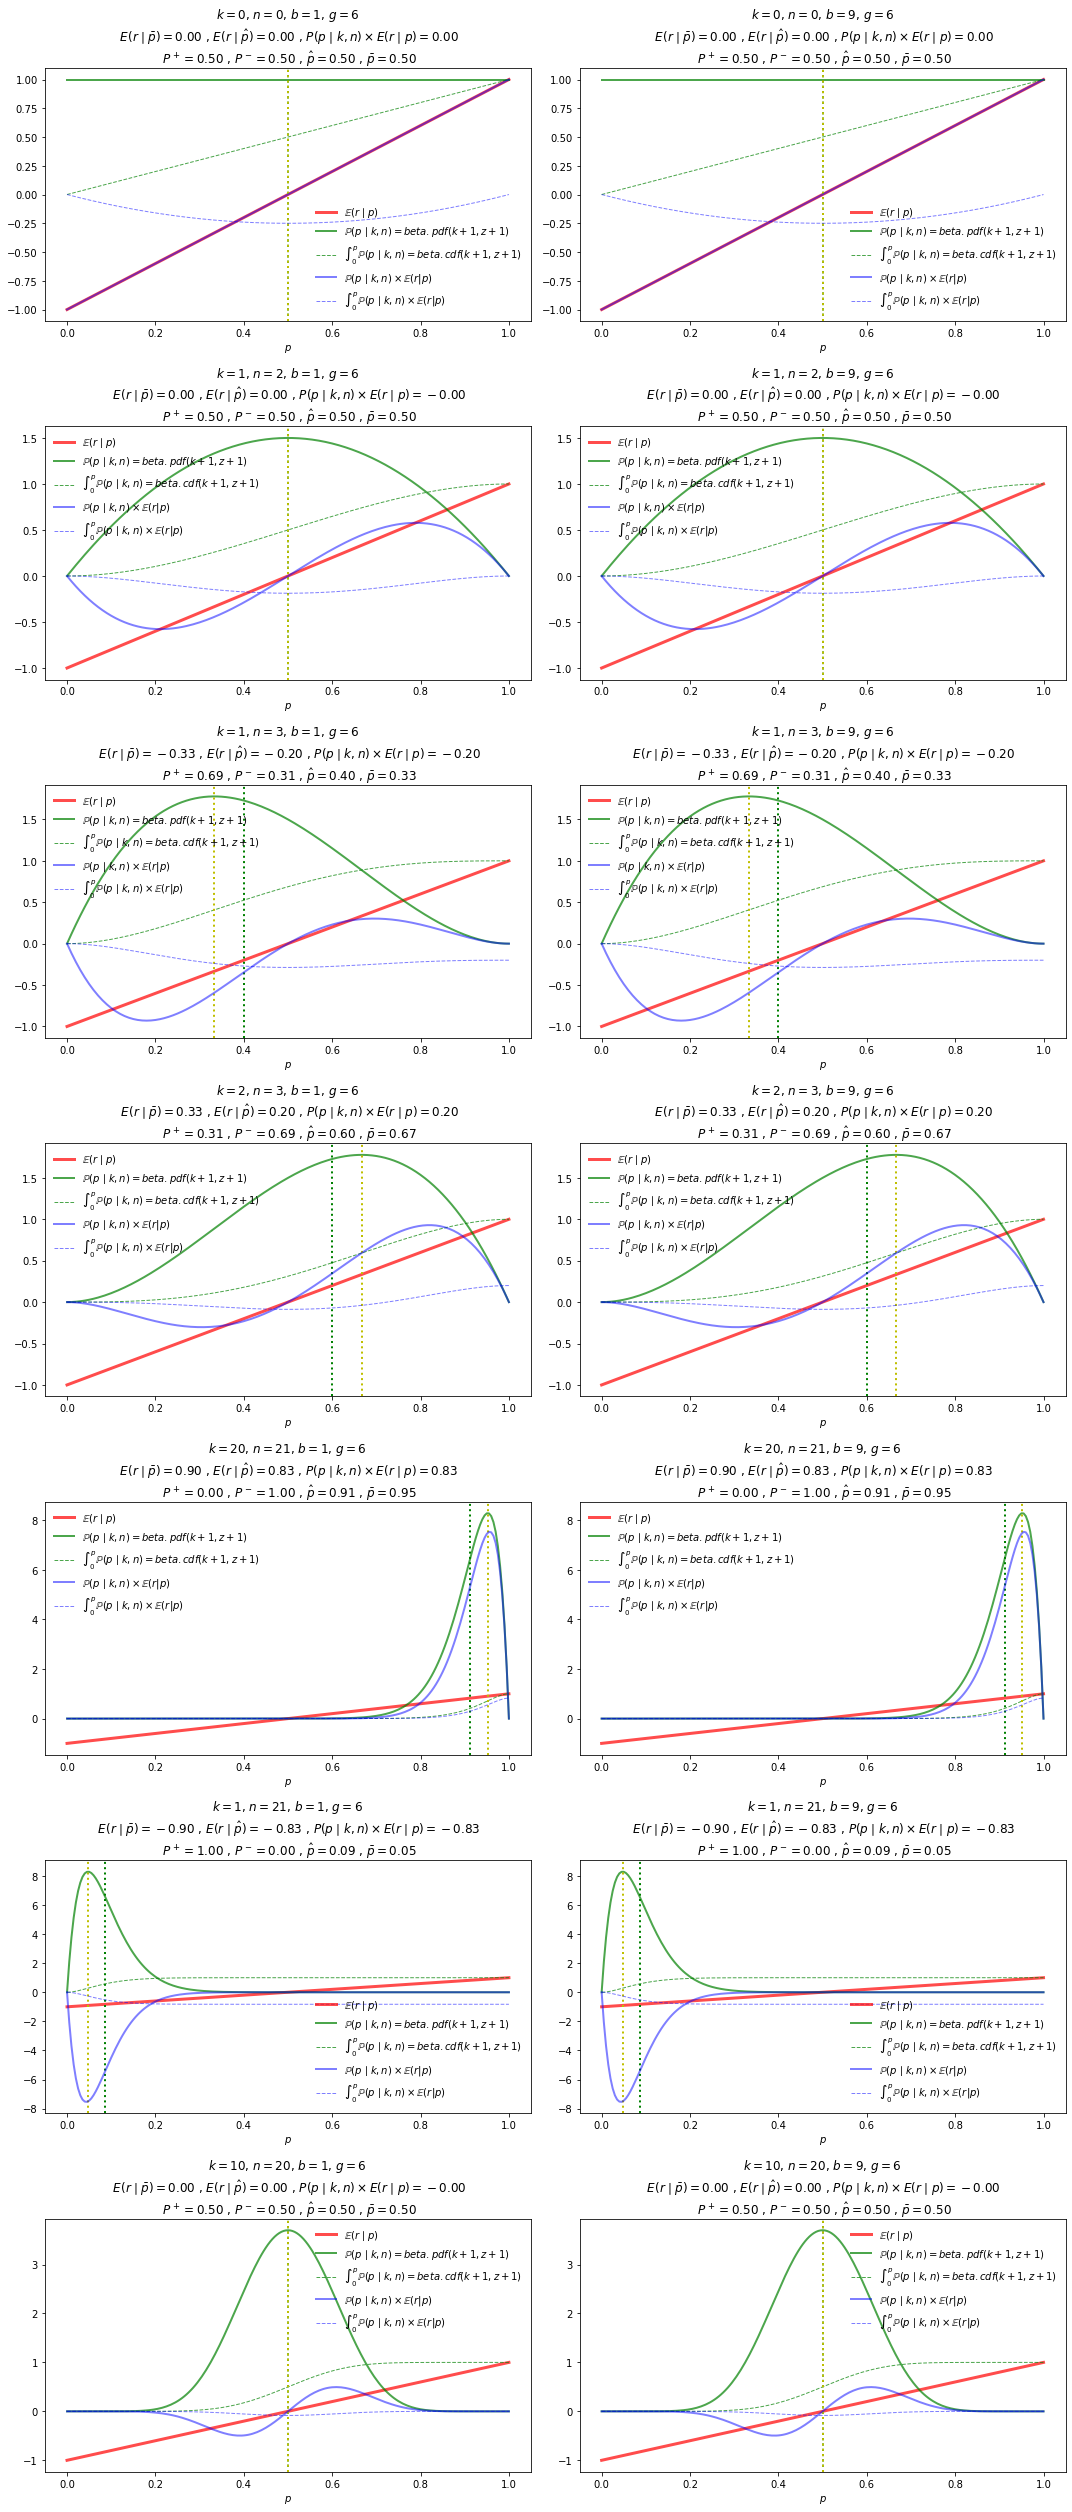

In [11]:
fig, ax = plt.subplots(arr_n_size, arr_b_size, figsize=(15, 35))
plt.subplots_adjust(hspace=0.5)

for idx_n in range(arr_n_size):
    k = arr_k[idx_n]
    z = arr_z[idx_n]
    p_hat = beta_mean_n[idx_n]
    r_hat = expected_r(p_hat)
    p_bar = beta_mode_n[idx_n]
    r_bar = expected_r(p_bar)
    r_beta = r_beta_area(k, z)
    r_beta_pos = expected_beta_posit(k, z)
    #r_beta_neg = expected_beta_negat(k, z)
    r_beta_neg = 1 - r_beta_pos 
    for idx_b in range(arr_b_size):
        b = arr_b[idx_b]
        ax[idx_n, idx_b].set_title(f'$k={k}$, $n={z+k}$, $b={b}$, $g={g}$ \n $E(r \\mid \\bar p) = {r_bar:.2f}$ , $E(r \\mid \\hat p) = {r_hat:.2f}$ , $P(p \mid k, n) \\times E(r \\mid p) = {r_beta:.2f}$ \n $P^+ = {r_beta_pos:.2f}$ , $P^- = {r_beta_neg:.2f}$ , $\\hat p = {p_hat:.2f}$ , $\\bar p = {p_bar:.2f}$')

        ax[idx_n, idx_b].plot(arr_p, arr_expected_r , 'r-', lw=3, alpha=0.7, label='$\mathbb{E}(r \mid p)$')

        ax[idx_n, idx_b].plot(arr_p, beta_pdf_np[idx_n] , 'g-', lw=2, alpha=0.7, label=r'$\mathbb{P}(p \mid k, n) = beta.pdf(k+1, z+1)$')
        ax[idx_n, idx_b].plot(arr_p, beta_cdf_np[idx_n] , 'g--', lw=1, alpha=0.7, label=r'$\int_0^p \mathbb{P}(p \mid k, n) = beta.cdf(k+1, z+1)$')
        ax[idx_n, idx_b].axvline(x=beta_mean_n[idx_n], color='g', lw=2, linestyle=':')
        ax[idx_n, idx_b].axvline(x=beta_mode_n[idx_n], color='y', lw=2, linestyle=':')

        ax[idx_n, idx_b].plot(arr_p, r_beta_prob_nbp[idx_n] , 'b-' , lw=2, alpha=0.5, label='$\mathbb{P}(p \mid k, n) \\times \mathbb{E}(r | p) $')
        ax[idx_n, idx_b].plot(arr_p, r_beta_cumu_nbp[idx_n] , 'b--', lw=1, alpha=0.5, label='$\int_0^p \mathbb{P}(p \mid k, n) \\times \mathbb{E}(r | p) $')

        ax[idx_n, idx_b].set_xlabel('$p$')
        ax[idx_n, idx_b].legend(loc='best', frameon=False)

fig.tight_layout()
plt.show()

In [13]:
#suppose a grid of col_size x row_size machines
col_size = 3
row_size = 3

#then k slot machines
cell_count = col_size * row_size

# k is the nuber of successes
arr_k = np.array(
    [[1, 10, 100],
     [2, 20, 200],
     [3, 30, 300]])

# z is the nuber of fails
arr_z = np.array(
    [[3, 30, 300],
     [2, 20, 200],
     [1, 10, 100]])

p=0.7
q=1-p
# k is the nuber of successes
arr_k = np.array(
    [[p*5, p*10, p*15],
     [p*20, p*25, p*30],
     [p*35, p*40, p*45]])

# z is the nuber of fails
arr_z = np.array(
    [[q*5, q*10, q*15],
     [q*20, q*25, q*30],
     [q*35, q*40, q*45]])

#prior = [1, 1]

#alpha and beta parameters considering prior
arr_alpha = arr_k+1
arr_beta = arr_z+1

#fixed budget
b = 3
g = 10

#win_prob given budget
win_prob_p = np.zeros((arr_p_size))
win_cumu_p = np.zeros((arr_p_size))
for idx_p in range(arr_p_size):
    win_prob_p[idx_p] = win_prob(arr_p[idx_p], b, g)
    win_cumu_p[idx_p] = win_cumu(arr_p[idx_p], b, g)

beta_pdf_ijp = np.zeros((col_size, row_size, arr_p_size))
beta_cdf_ijp = np.zeros((col_size, row_size, arr_p_size))
beta_mean_ij = np.zeros((col_size, row_size))
beta_medi_ij = np.zeros((col_size, row_size))
beta_mode_ij = np.zeros((col_size, row_size))

win_beta_prob_ijp = np.zeros((col_size, row_size, arr_p_size))
win_beta_cumu_ijp = np.zeros((col_size, row_size, arr_p_size))

for i in range(col_size):
    for j in range(row_size):
        beta_pdf_ijp[i][j] = beta_dist.pdf(arr_p, arr_alpha[i][j], arr_beta[i][j])  
        beta_cdf_ijp[i][j] = beta_dist.cdf(arr_p, arr_alpha[i][j], arr_beta[i][j])  
        beta_mean_ij[i][j] = beta_dist.mean(arr_alpha[i][j], arr_beta[i][j])
        beta_medi_ij[i][j] = beta_dist.median(arr_alpha[i][j], arr_beta[i][j])
        #beta_mode_ij[i][j] = beta_mode(arr_k[i][j], arr_z[i][j])
        for idx_p in range(arr_p_size):
            win_beta_prob_ijp[i][j][idx_p] = win_beta_prob(arr_p[idx_p], arr_k[i][j], arr_z[i][j], b, g)
            win_beta_cumu_ijp[i][j][idx_p] = win_beta_cumu(arr_p[idx_p], arr_k[i][j], arr_z[i][j], b, g)


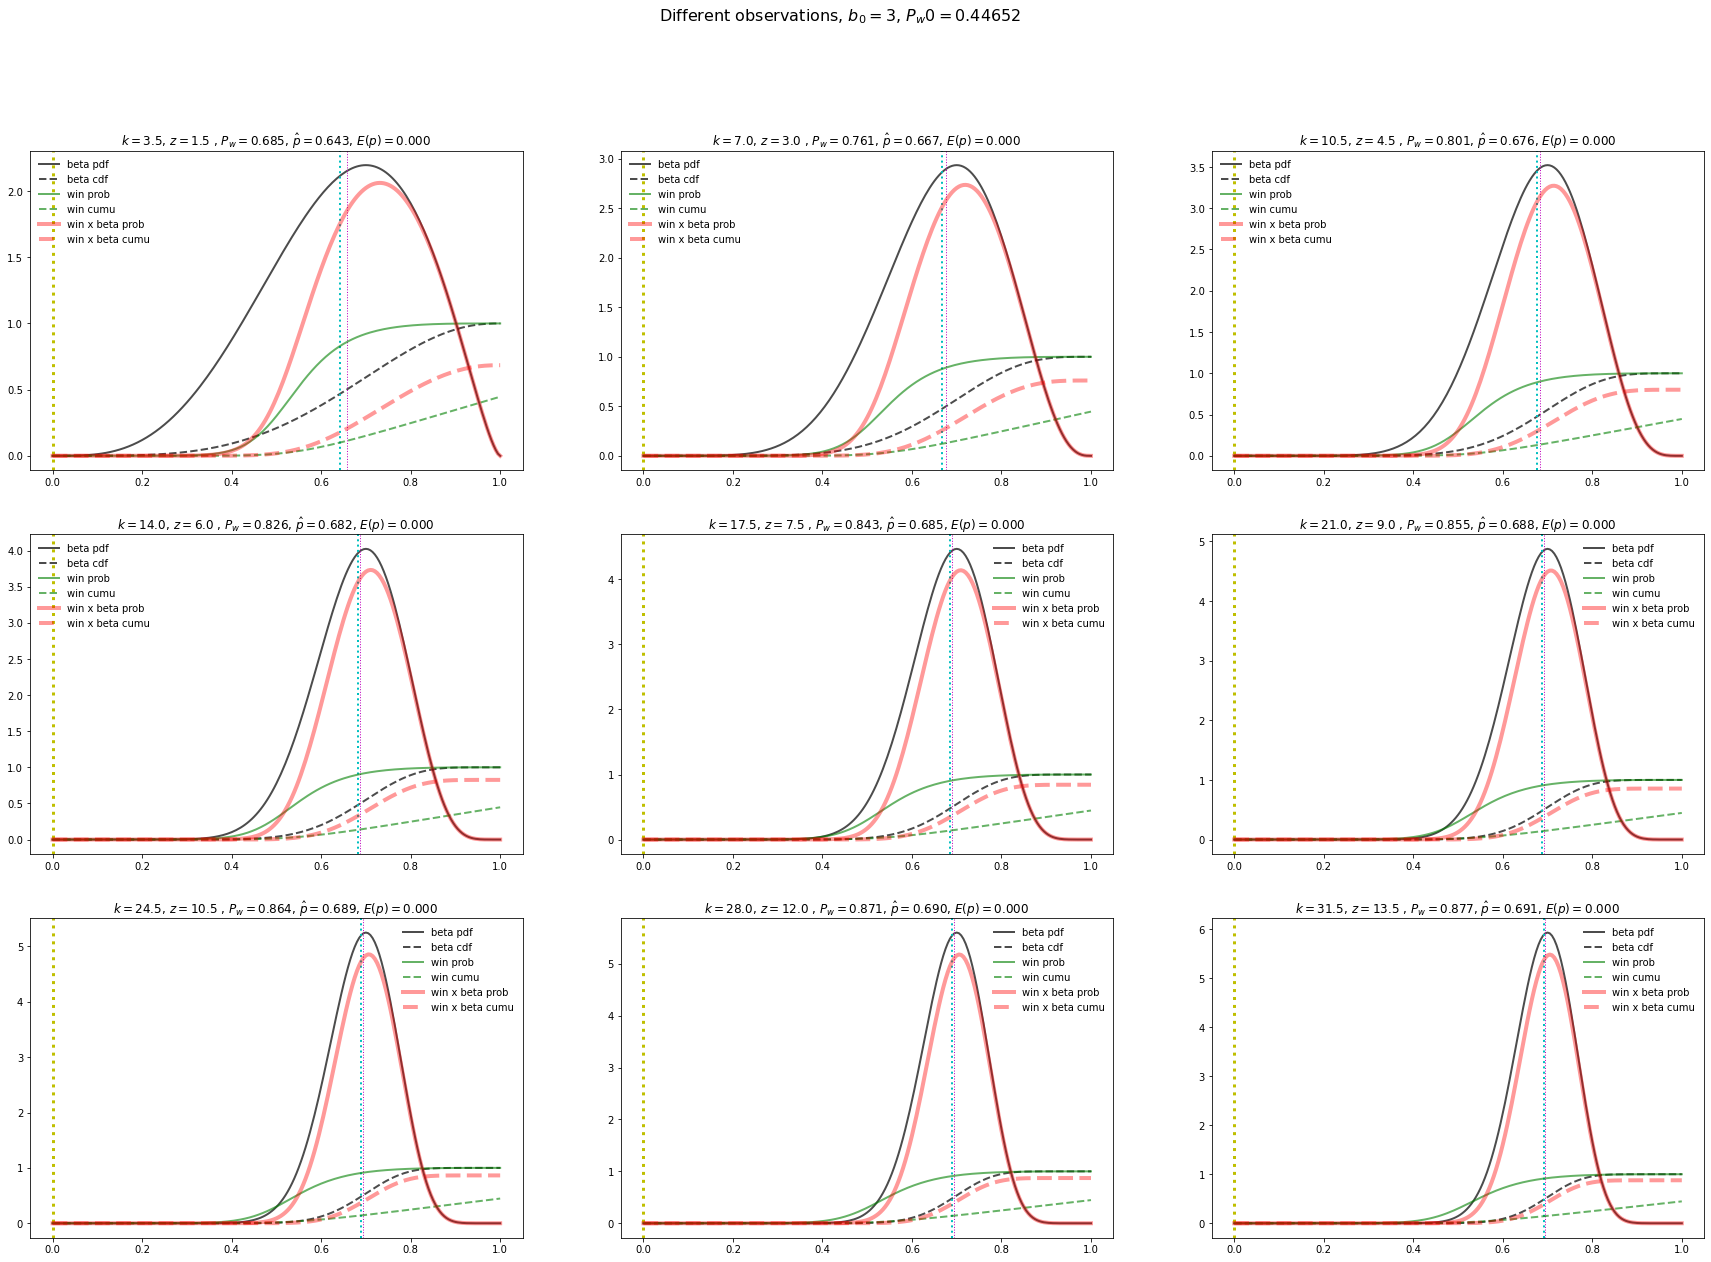

In [14]:
fig, ax = plt.subplots(col_size, row_size, figsize=(30, 20))

fig.suptitle(f'Different observations, $b_0={b}$, $P_w0={win_beta_area(0, 0, b, g):.5f}$' , fontsize=16)

for i in range(col_size):
    for j in range(row_size):
        k = arr_k[i][j]
        z = arr_z[i][j]
        pw = win_beta_area(k, z, b, g)
        phat = beta_mean_ij[i][j]
        pbar = beta_mode_ij[i][j]
        ax[i,j].set_title(f'$k={k:.1f}$, $z={z:.1f}$ , $P_w={pw:.3f}$, $\\hat p={phat:.3f}$, $E(p)={pbar:.3f}$ ')
        #ax[i,j].set_xlabel('p')
        #ax[i,j].hist(samples[i][j], density=True, histtype='stepfilled', alpha=0.2)
        ax[i,j].plot(arr_p, beta_pdf_ijp[i][j] , 'k-', lw=2, alpha=0.7, label='beta pdf')
        ax[i,j].plot(arr_p, beta_cdf_ijp[i][j] , 'k--', lw=2, alpha=0.7, label='beta cdf')
        ax[i,j].axvline(x=beta_mean_ij[i][j], color='c', lw=2, linestyle=':')
        ax[i,j].axvline(x=beta_medi_ij[i][j], color='m', lw=1, linestyle=':')
        ax[i,j].axvline(x=beta_mode_ij[i][j], color='y', lw=3, linestyle=':')
        ax[i,j].plot(arr_p, win_prob_p , 'g-',  lw=2, alpha=0.6, label='win prob')
        ax[i,j].plot(arr_p, win_cumu_p , 'g--', lw=2, alpha=0.6, label='win cumu')
        ax[i,j].plot(arr_p, win_beta_prob_ijp[i][j] , 'r-' , lw=4, alpha=0.4, label='win x beta prob')
        ax[i,j].plot(arr_p, win_beta_cumu_ijp[i][j] , 'r--', lw=4, alpha=0.4, label='win x beta cumu')
        ax[i,j].legend(loc='best', frameon=False)
        
plt.show()


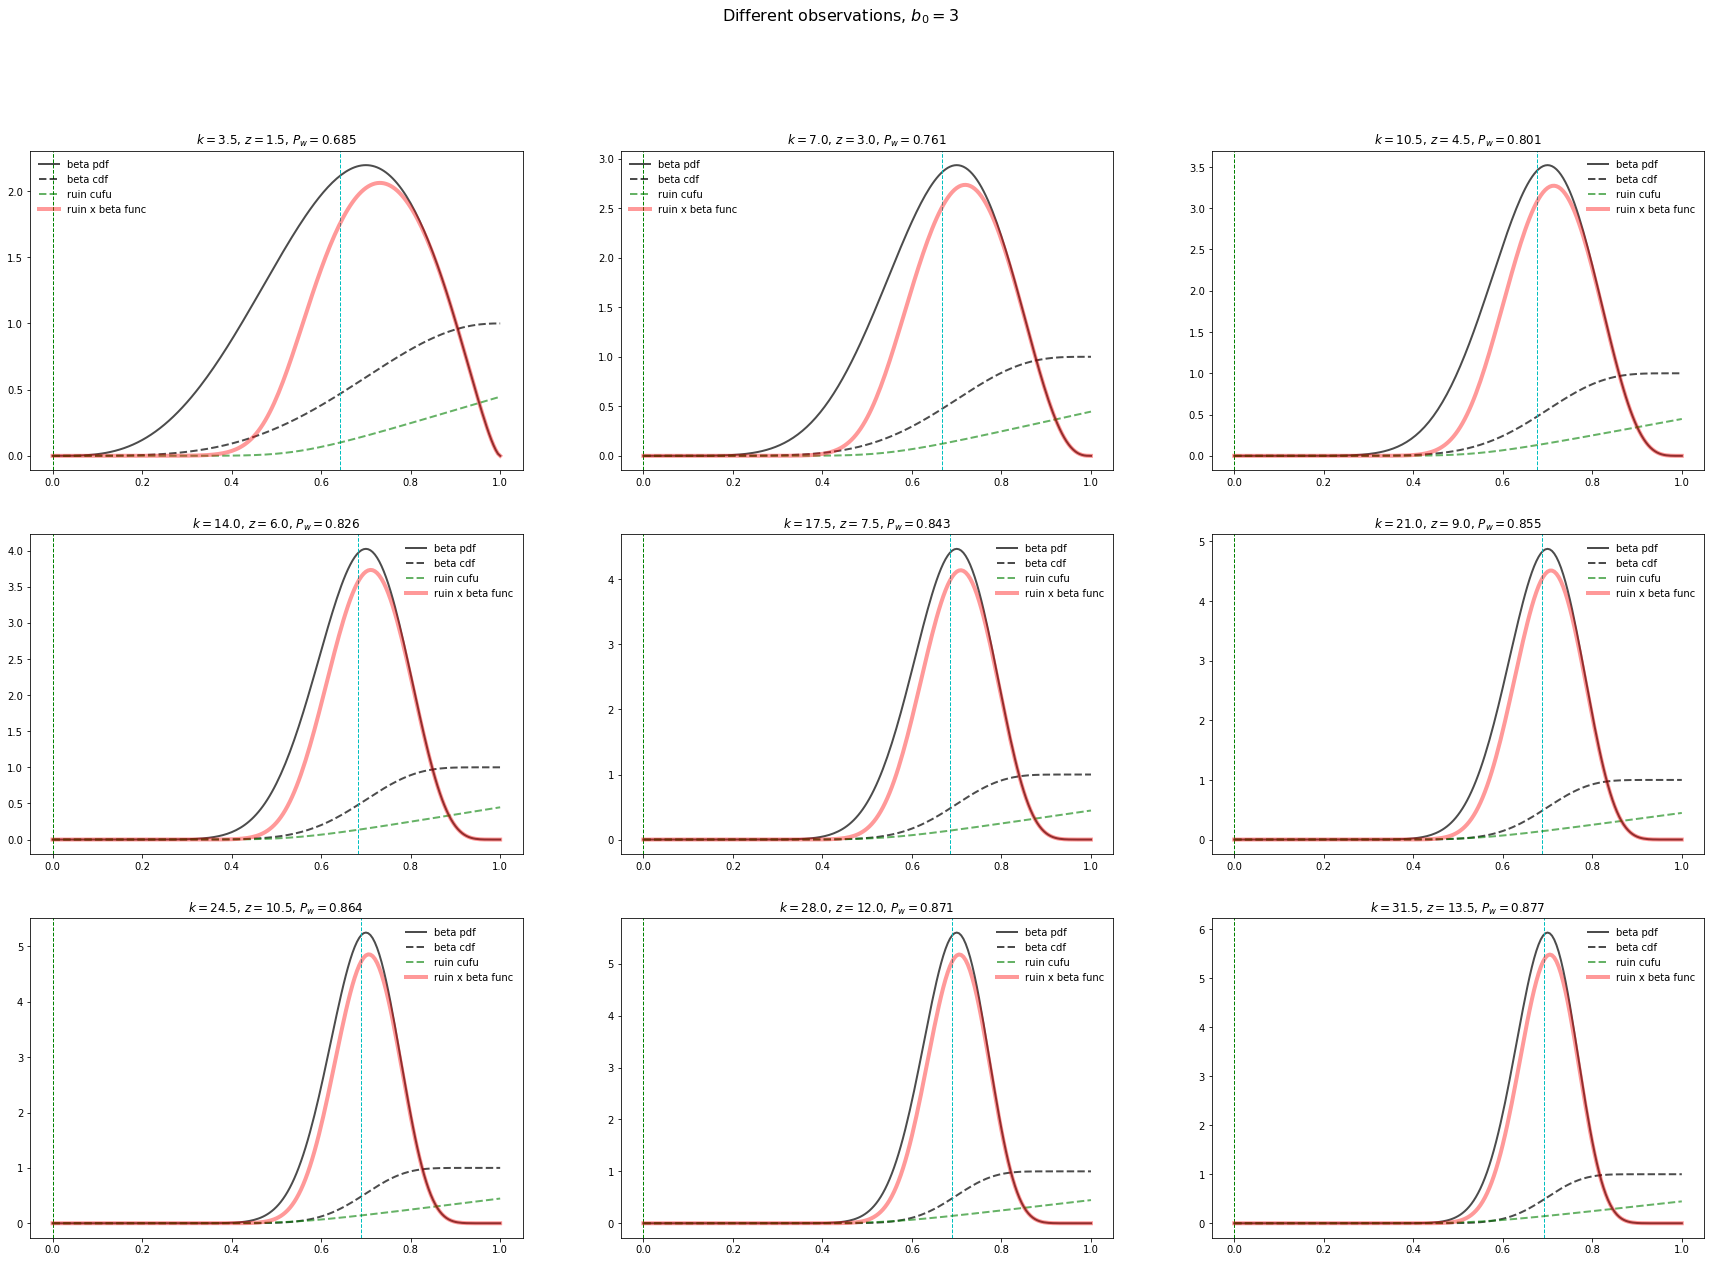

In [15]:
fig, ax = plt.subplots(col_size, row_size, figsize=(30, 20))

fig.suptitle(f'Different observations, $b_0={b}$' , fontsize=16)

for i in range(col_size):
    for j in range(row_size):
        ax[i,j].set_title(f'$k={arr_k[i][j]:.1f}$, $z={arr_z[i][j]:.1f}$, $P_w={win_beta_area(arr_k[i][j], arr_z[i][j], b, g):.3f}$')
        #ax[i,j].set_xlabel('p')
        #ax[i,j].hist(samples[i][j], density=True, histtype='stepfilled', alpha=0.2)
        ax[i,j].plot(arr_p, beta_pdf_ijp[i][j] , 'k-', lw=2, alpha=0.7, label='beta pdf')
        ax[i,j].plot(arr_p, beta_cdf_ijp[i][j] , 'k--', lw=2, alpha=0.7, label='beta cdf')
        ax[i,j].axvline(x=beta_mean_ij[i][j], color='c', lw=1, linestyle='--')
        ax[i,j].axvline(x=beta_mode_ij[i][j], color='g', lw=1, linestyle='--')
        #ax[i,j].plot(arr_p, win_func_p , 'g-',  lw=2, alpha=0.6, label='ruin func')
        ax[i,j].plot(arr_p, win_cumu_p , 'g--', lw=2, alpha=0.6, label='ruin cufu')
        ax[i,j].plot(arr_p, win_beta_prob_ijp[i][j] , 'r-' , lw=4, alpha=0.4, label='ruin x beta func')
        #ax[i,j].plot(arr_p, win_beta_cufu_xyp[i][j] , 'r--', lw=4, alpha=0.4, label='ruin x beta cufu')
        ax[i,j].legend(loc='best', frameon=False)
        
plt.show()


Probability of Ruin

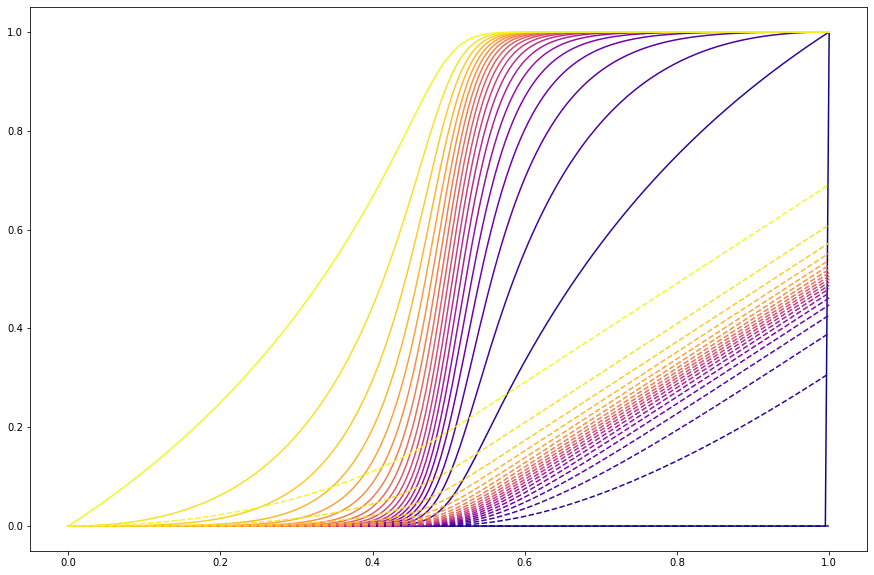

In [16]:

g=20
arr_b_size = 20
arr_b = range(arr_b_size)

win_prob_pb = np.zeros((arr_b_size, arr_p_size))
win_cumu_pb = np.zeros((arr_b_size, arr_p_size))

for idx_p in range(arr_p_size):
    for idx_b in range(arr_b_size):
        win_prob_pb[idx_b][idx_p] = win_prob(arr_p[idx_p], arr_b[idx_b], g)
        win_cumu_pb[idx_b][idx_p] = win_cumu(arr_p[idx_p], arr_b[idx_b], g)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

arr_color_idx = np.linspace(0, 1, arr_b_size)

for idx_b in range(arr_b_size):
    plt.plot(arr_p, win_prob_pb[idx_b] , color=plt.cm.plasma(arr_color_idx[idx_b]), label='ruin probabilities')
    plt.plot(arr_p, win_cumu_pb[idx_b] , color=plt.cm.plasma(arr_color_idx[idx_b]), linestyle='--', label='ruin cumulative probabilities')
      
plt.show()


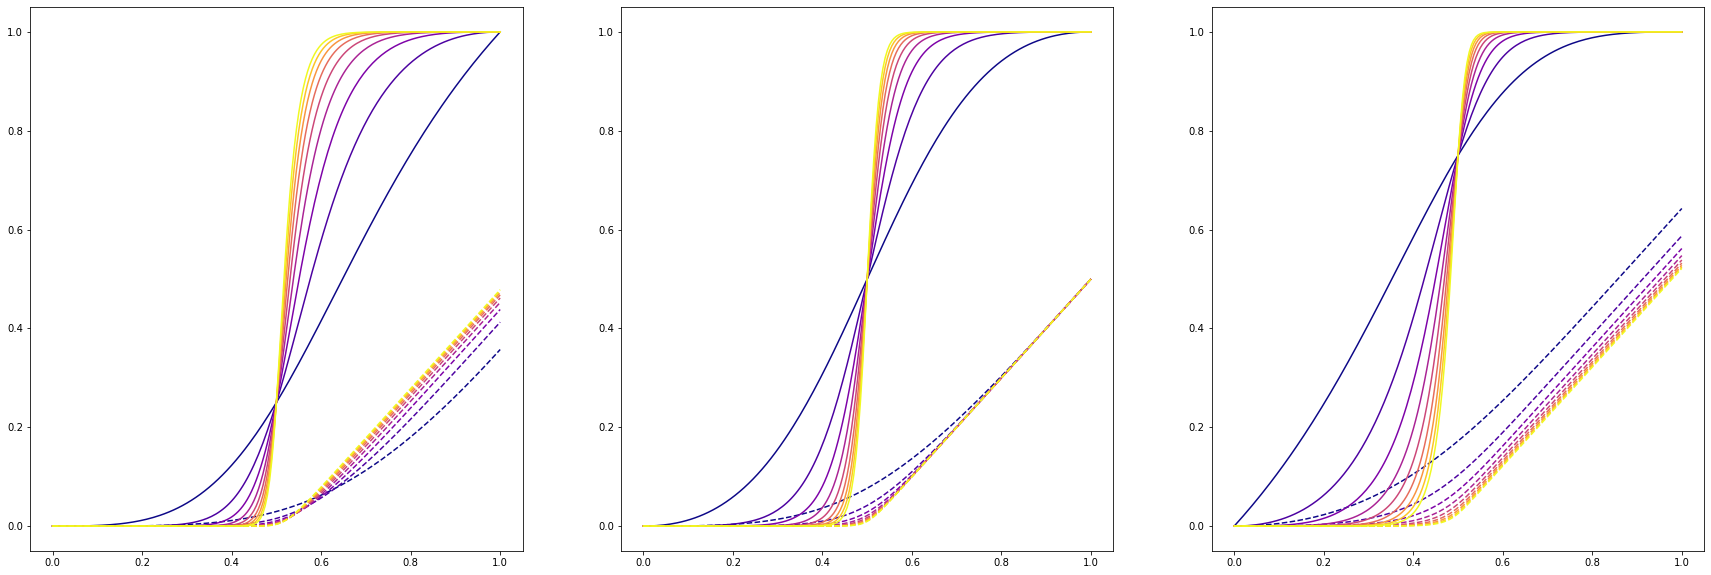

In [17]:

arr_g_size = 9
arr_g_factor = range(1,10)
g_base = 4

arr_b_size = 3
arr_b_base = [1, 2, 3]

win_prob_pg = np.zeros((arr_b_size, arr_g_size, arr_p_size))
win_cumu_pg = np.zeros((arr_b_size, arr_g_size, arr_p_size))

for idx_p in range(arr_p_size):
    p = arr_p[idx_p]
    for idx_g in range(arr_g_size):
        g = g_base * arr_g_factor[idx_g]
        for idx_b in range(arr_b_size):
            b = arr_b_base[idx_b] * arr_g_factor[idx_g]
            win_prob_pg[idx_b][idx_g][idx_p] = win_prob(p, b, g)
            win_cumu_pg[idx_b][idx_g][idx_p] = win_cumu(p, b, g)

fig, ax = plt.subplots(1, arr_b_size, figsize=(30, 10))

arr_color_idx = np.linspace(0, 1, arr_g_size)

for idx_b in range(arr_b_size):
    for idx_g in range(arr_g_size):
        ax[idx_b].plot(arr_p, win_prob_pg[idx_b][idx_g] , color=plt.cm.plasma(arr_color_idx[idx_g]), label='ruin probabilities')
        ax[idx_b].plot(arr_p, win_cumu_pg[idx_b][idx_g] , color=plt.cm.plasma(arr_color_idx[idx_g]), linestyle='--', label='ruin cumulative probabilities')
      
plt.show()



In [18]:
# always chose play
def always_play_method(b, g, k=0, z=0, p=None, f=(lambda b, g : b)):
    return True

# always chose quit
def always_quit_method(b, g, k=0, z=0, p=None, f=(lambda b, g : b)):
    return False

# chose play if the known probability of succes is higher than the probability of fail
# or equivalently when the expected budget in the next step is higher than the current one 
def oracle_naive_method(b, g, k=0, z=0, p=None, f=(lambda b, g : b)):
    return (p >= 0.5)

# chose play if the probability of winning the game given the known probability of succes is higher than the probability of being ruined
def oracle_simple_method(b, g, k=0, z=0, p=None, f=(lambda b, g : b)):
    w = win_prob(p, b, g)
    return (w >= 0.5)

# chose play if the expected budget in the next step has a higher utility than the current one 
def oracle_local_method(b, g, k=0, z=0, p=None, f=(lambda b, g : b)):
    return (((p * f(b+1, g)) + ((1-p) * f(b-1, g))) >= f(b, g))

# chose play if the expected budget at the end of the game has a higher utility than the current one 
def oracle_global_method(b, g, k=0, z=0, p=None, f=(lambda b, g : b)):
    w = win_prob(p, b, g)
    return (((w * f(g, g)) + ((1-w) * f(0, g))) >= f(b, g))

# chose play if the estimated frequentist probability of succes is higher than the probability of fail
# or equivalently when the expected budget in the next step is higher than the current one 
def freq_naive_method(b, g, k=0, z=0, p=None, f=(lambda b, g : b)):
    if (k+z>0):
        p_bar = k/(k+z)
        return (p_bar >= 0.5)
    else:
        return True

# chose play if the probability of winning the game given the estimated frequentist probability of succes is higher than the probability of being ruined
def freq_simple_method(b, g, k=0, z=0, p=None, f=(lambda b, g : b)):
    if (k+z>0):
        p_bar = k/(k+z)
        w_bar = win_prob(p_bar, b, g)
        return (w_bar >= 0.5)
    else:
        return True

# chose play if the utility of the expected budget in the next step is higher than the current one 
def freq_local_method(b, g, k=0, z=0, p=None, f=(lambda b, g : b)):
    if (k+z>0):
        p_bar = k/(k+z)
        return (((p_bar * f(b+1, g)) + ((1-p_bar) * f(b-1, g))) >= f(b, g))
    else:
        return True

# chose play if the expected budget at the end of the game given the frequentist estimation of p has a higher utility than the current one 
def freq_global_method(b, g, k=0, z=0, p=None, f=(lambda b, g : b)):
    if (k+z>0):
        p_bar = k/(k+z)
        w_bar = win_prob(p_bar, b, g)
        return (((w_bar * f(g, g)) + ((1-w_bar) * f(0, g))) >= f(b, g))
    else:
        return True

def freq_final_method(b, g, k=0, z=0, p=None, f=(lambda b, g : b)):
    if (k+z>0):
        p_bar = k/(k+z)
        return (p_bar >= 0.5) or (p_bar*f(g, g) >= f(b,g))
    else:
        return True

def bayes_final_method(b, g, k=0, z=0, p=None, f=(lambda b, g : b)):
    p_hat = (k+1)/(k+z+2)
    return (p_hat >= 0.5) or (p_hat*f(g, g) >= f(b,g))

def beta_method(b, g, k=0, z=0, p=None, f=(lambda b, g : b)):
    return (win_beta_area(k, z, b, g)*f(g, g) >= f(b,g))

def opportunist_method(b, g, k=0, z=0, p=None, f=(lambda b, g : b)):
    p_hat = (k+1)/(k+z+2)
    return (p_hat >= 0.5) or (win_beta_area(k, z, b, g)*f(g, g) >= f(b,g))

def bayes_naive_method(b, g, k=0, z=0, p=None, f=(lambda b, g : b)):
    p_hat = (k+1)/(k+z+2)
    return (p_hat >= 0.5)

def bayes_simple_method(b, g, k=0, z=0, p=None, f=(lambda b, g : b)):
    p_hat = (k+1)/(k+z+2)
    w_hat = win_prob(p_hat, b, g)
    return (w_hat >= 0.5)

def bayes_local_method(b, g, k=0, z=0, p=None, f=(lambda b, g : b)):
    p_hat = (k+1)/(k+z+2)
    return (((p_hat * f(b+1, g)) + ((1-p_hat) * f(b, g))) >= f(b-1, g))

def bayes_global_method(b, g, k=0, z=0, p=None, f=(lambda b, g : b)):
    p_hat = (k+1)/(k+z+2)
    w_hat = win_prob(p_hat, b, g)
    return (((w_hat * f(g, g)) + ((1-w_hat) * f(0, g))) >= f(b, g))

def our_naive_method(b, g, k=0, z=0, p=None, f=(lambda b, g : b)):
    return (win_beta_cumu(0.5, k, z, b, g) >= 0.5)

def our_simple_method(b, g, k=0, z=0, p=None, f=(lambda b, g : b)):
    return (win_beta_area(k, z, b, g) >= 0.5)

#def our_local_method(b, g, k=0, z=0, p=None, f=(lambda b, g : b)):
#    w = win_beta_area(k, z, b, g)
#    return (((w * f(b+1, g)) + ((1-w) * f(b-1, g))) > f(b, g))
# -> no sense !

def our_global_method(b, g, k=0, z=0, p=None, f=(lambda b, g : b)):
    w = win_beta_area(k, z, b, g)
    return (((w * f(g, g)) + ((1-w) * f(0, g))) >= f(b, g))


In [19]:
%%time

#samples for p
arr_p_size = 31

arr_p = np.linspace(0, 1, arr_p_size)

arr_g_factor = [1, 5] # [1, 2, 3, 4, 5, 10]
arr_g_size = len(arr_g_factor)
g_base = 4

arr_b_base = [1, 2, 3]
arr_b_size = len(arr_b_base)

num_games = 31

########################################
#findings for f = b: [for each p] (in average)

# A = always_quit   [==] our_naive
# B = always_play
# C = oracle_naive  [==] oracle_global
# D = oracle_simple [==] oracle_local
# E = freq_naive    [==] freq_global   [==]   freq_local   [==]  bayes_naive  [==]  bayes_global  [==]  bayes_local  
# F = freq_simple
# G = bayes_simple
# H = our_simple

# A [!=](~~) B

# A [!=](>)  B   :    if b_0 < g/2
# A [!=](==) B   :    if b_0 = g/2
# A [!=](<)  B   :    if b_0 > g/2

# C [>=](>)  D

# E [!=](>=) F [!=](>=) G 

# E [==]     F [==]     G  :  if b_0 >= g/2
# E [!=](>)  F [!=](>)  G  :  if b_0 <  g/2 

# E [!=](>)  A

# E [!=](>=) H

########################################

arr_methods = []
arr_methods += [always_quit_method]
arr_methods += [always_play_method]
arr_methods += [oracle_naive_method]
#arr_methods += [oracle_simple_method]
#REMOVED : arr_methods += [oracle_local_method] #equivalent to oracle_simple_method for f=b
#REMOVED : arr_methods += [oracle_global_method] #equivalent to oracle_naive_method for f=b
arr_methods += [freq_naive_method]
#arr_methods += [freq_simple_method]
#arr_methods += [freq_final_method]
arr_methods += [beta_method]
arr_methods += [opportunist_method]
#arr_methods += [bayes_final_method]
#arr_methods += [freq_final_method]
#REMOVED : arr_methods += [freq_local_method, freq_global_method] #equivalent to freq_naive_method for f=b
#arr_methods += [bayes_simple_method]
#REMOVED : arr_methods += [our_naive_method] #equivalent to always_quit_method for f=b
#REMOVED : arr_methods += [our_local_method] #no sense method
#arr_methods += [our_global_method]
#REMOVED : arr_methods += [bayes_naive_method, bayes_local_method, bayes_global_method] #equivalent to freq_naive_method for f=b

#arr_methods = [bayes_local_method, freq_naive_method]

num_methods = len(arr_methods)

final_b = np.zeros((arr_b_size, arr_g_size, num_methods, arr_p_size))
final_f = np.zeros((arr_b_size, arr_g_size, num_methods, arr_p_size))
final_n = np.zeros((arr_b_size, arr_g_size, num_methods, arr_p_size))

theoretical_always_quit = np.zeros((arr_b_size, arr_g_size, arr_p_size))
theoretical_always_play = np.zeros((arr_b_size, arr_g_size, arr_p_size))
theoretical_play_quit = np.zeros((arr_b_size, arr_g_size, arr_p_size))
theoretical_oracle_naive = np.zeros((arr_b_size, arr_g_size, arr_p_size))
theoretical_freq_naive = np.zeros((arr_b_size, arr_g_size, arr_p_size))
theoretical_always_quit_score = np.zeros((arr_b_size, arr_g_size))
theoretical_always_play_score = np.zeros((arr_b_size, arr_g_size))
theoretical_play_quit_score = np.zeros((arr_b_size, arr_g_size))
theoretical_oracle_naive_score = np.zeros((arr_b_size, arr_g_size))
theoretical_freq_naive_score = np.zeros((arr_b_size, arr_g_size))

#f = lambda b, g : b
f = lambda b, g : b/g
#f = lambda b, g : 0 if b==0 else (+1 if b==g else 0.5)

arr_x_size = 1000
max_duration = 2000

#theoretical
for idx_g in range(arr_g_size): 
  g = g_base * arr_g_factor[idx_g]
  for idx_b in range(arr_b_size): 
    b0 = arr_b_base[idx_b] * arr_g_factor[idx_g]
    theoretical_always_quit[idx_b, idx_g] = np.repeat(f(b0,g), arr_p_size)
    theoretical_always_quit_score[idx_b, idx_g] = f(b0,g)
    theoretical_always_play[idx_b, idx_g] = np.array([f(win_prob(p, b0, g) * g, g) for p in arr_p]) 
    theoretical_always_play_score[idx_b, idx_g] = f(win_area(b0, g) * g, g)
    theoretical_play_quit[idx_b, idx_g] = np.array([f(win_prob(p, b0, g) * g, g) for p in arr_p])  if b0 < g/2 else  np.repeat(f(b0,g), arr_p_size)
    theoretical_play_quit_score[idx_b, idx_g] = f(win_area(b0, g) * g, g)  if b0 < g/2 else  f(b0,g)
    theoretical_oracle_naive[idx_b, idx_g] = np.array([f(win_prob(p, b0, g) * g if p > 0.5 else b0, g) for p in arr_p]) 
    theoretical_oracle_naive_score[idx_b, idx_g] = f((b0*0.5)+(win_cumu(1, b0, g, 0.5) * g), g)
    theoretical_freq_naive[idx_b, idx_g] = np.array([f( (win_prob(p, 1, g-b0+1) * g) + ((1-win_prob(p, 1, g-b0+1)) * (b0-1)), g) for p in arr_p]) 
    theoretical_freq_naive_score[idx_b, idx_g] = f((win_area(1, g-b0+1) * g) + ( (1-win_area(1, g-b0+1)) * (b0-1)), g)

#simulation
for idx_p in tqdm(range(arr_p_size), desc='varying success parameter', leave=True): 
  p = arr_p[idx_p]
  for idx_game in range(num_games):
    arr_x = np.random.binomial(1, p, size=arr_x_size)
    #for idx_g in tqdm(range(arr_g_size), desc='varying total fortune', leave=False): 
    for idx_g in range(arr_g_size): 
      g = g_base * arr_g_factor[idx_g]
      #for idx_b in tqdm(range(arr_b_size), desc='varying initial budget', leave=False): 
      for idx_b in range(arr_b_size): 
        b0 = arr_b_base[idx_b] * arr_g_factor[idx_g]
        for idx_method in range(num_methods): 
          method = arr_methods[idx_method]
          b = b0
          k = 0
          z = 0
          n = 0
          while method(b, g, k, z, p, f) and b>0 and b<g and ((max_duration is None) or (n < max_duration)) :
            x = arr_x[n % arr_x_size]
            r = 2*x-1
            b = b+r
            k = k+x
            n = n+1
            z = n-k
          final_b[idx_b, idx_g, idx_method, idx_p] = final_b[idx_b, idx_g, idx_method, idx_p] + (b / num_games)
          final_f[idx_b, idx_g, idx_method, idx_p] = final_f[idx_b, idx_g, idx_method, idx_p] + (f(b, g) / num_games)
          final_n[idx_b, idx_g, idx_method, idx_p] = final_n[idx_b, idx_g, idx_method, idx_p] + (n / num_games)

average_b = np.mean(final_b, axis=3)
average_f = np.mean(final_f, axis=3)
average_n = np.mean(final_n, axis=3)

#print(final_b)
#print(final_n)


varying success parameter:   0%|          | 0/31 [00:00<?, ?it/s]

Wall time: 8min 9s


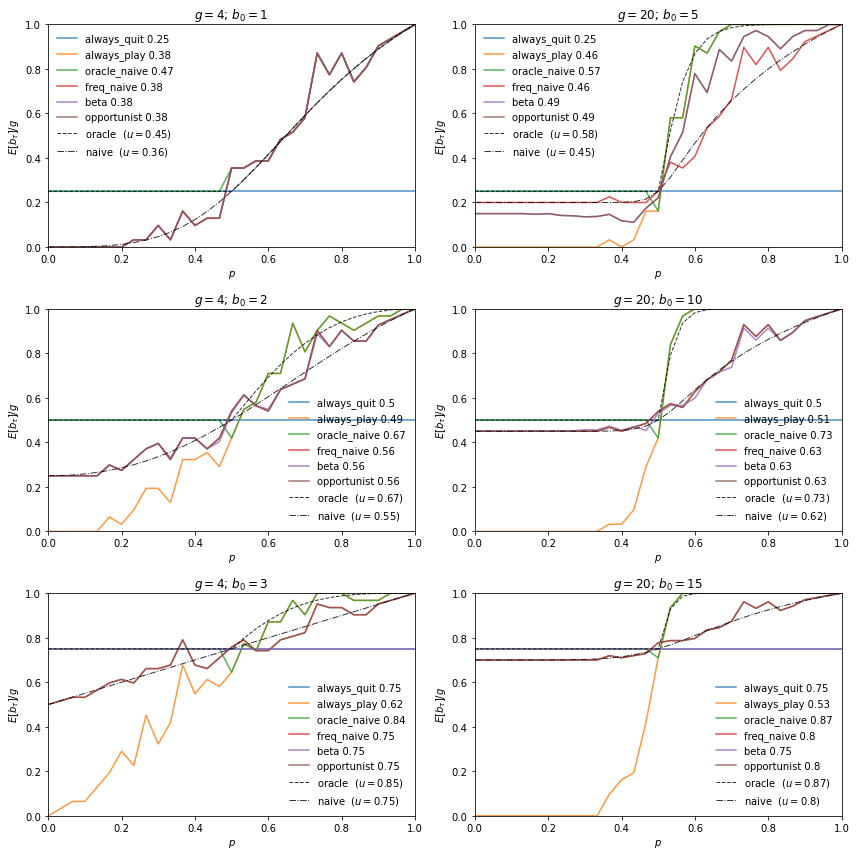

In [20]:
fig, ax = plt.subplots(arr_b_size, arr_g_size, figsize=(12, 12))

#arr_color_idx = plt.cm.plasma(np.linspace(0, 1, num_methods))
#arr_color_idx = plt.cm.brg(np.linspace(0, 1, num_methods))
arr_color_idx = ['b', 'r', 'g', 'k', 'y']
arr_color_size = len(arr_color_idx)
arr_line_idx = ['-', '--', ':']
arr_line_size = len(arr_line_idx)

marks = 1

for idx_b in range(arr_b_size):
    for idx_g in range(arr_g_size):
        b0 = arr_b_base[idx_b] * arr_g_factor[idx_g]
        g = g_base * arr_g_factor[idx_g]
        ax[idx_b, idx_g].set_title(f'$g={g}$; $b_0={b0}$') #b_0={b0/g:.2}g
        for idx_method in range(num_methods):
            #ax[idx_b, idx_g].plot(arr_p, final_f[idx_b, idx_g, idx_method] , color=arr_color_idx[idx_method%arr_color_size], linestyle=arr_line_idx[idx_method*arr_line_size//num_methods] , lw=idx_method//(num_methods//arr_line_size)*2+2, alpha=0.5, label=arr_methods[idx_method].__name__[:-7])
            ax[idx_b, idx_g].plot(arr_p, final_f[idx_b, idx_g, idx_method] , alpha=0.8, label=arr_methods[idx_method].__name__[:-7] + f' {average_f[idx_b, idx_g, idx_method]:.2}' )
        ax[idx_b, idx_g].set(xlim=(0, 1), ylim=(f(0,g), f(g,g)))
        ax[idx_b, idx_g].plot(arr_p, theoretical_oracle_naive[idx_b, idx_g], alpha=0.8, color='k', lw=1, linestyle='--', marker='', mfc='none', markersize=10, markevery=marks, label='oracle ' + f' ($u = {theoretical_oracle_naive_score[idx_b, idx_g]:.2}$)' )
        #ax[idx_b, idx_g].plot(arr_p, theoretical_always_quit[idx_b, idx_g],  alpha=0.8, color='k', lw=1, linestyle=':', marker='', mfc='none', markersize=6,  markevery=marks, label='timid '  + f' ($u = {theoretical_always_quit_score[idx_b, idx_g]:.2}$)' )
        #ax[idx_b, idx_g].plot(arr_p, theoretical_always_play[idx_b, idx_g],  alpha=0.8, color='k', lw=1, linestyle='-', marker='', mfc='none', markersize=6,  markevery=marks, label='bold '   + f' ($u = {theoretical_always_play_score[idx_b, idx_g]:.2}$)' )
        ax[idx_b, idx_g].plot(arr_p, theoretical_freq_naive[idx_b, idx_g], alpha=0.8,   color='k', lw=1, linestyle='-.', marker='', mfc='none', markersize=8,  markevery=marks, label='naive '   + f' ($u = {theoretical_freq_naive_score[idx_b, idx_g]:.2}$)' )
        #ax[idx_b, idx_g].plot(arr_p, theoretical_play_quit[idx_b, idx_g], alpha=0.4,   color='r', lw=6, linestyle='',  label='potential' + f' ($u = {theoretical_play_quit_score[idx_b, idx_g]:.2}$)' )
        #if idx_b != 1:
        ax[idx_b, idx_g].legend(loc='best', frameon=False)
        ax[idx_b, idx_g].set_xlabel('$p$')
        ax[idx_b, idx_g].set_ylabel('$E[b_{\\tau}] / g$')
#ax[2][1].set_xlabel('$p$  (probability of success)')
#ax[1][0].set_ylabel('$E[b_\tau] / g$  (epected value of the target optimization function)')

#fig.suptitle('Number of possible paths from a given initial budget to achieve another budget level.')
fig.tight_layout()

plt.savefig('basic_strategies.pdf', bbox_inches='tight')

if COLAB:
    files.download('basic_strategies.pdf')

plt.show()

#print(arr_p)

In [21]:
%%time

arr_g_factor = [1, 10] # [1, 2, 3, 4, 5, 10]
arr_g_size = len(arr_g_factor)
g_base = 4
g_lcm = np.lcm.reduce(arr_g_factor)

#samples for ratio : b0/g
ratio_factor = 10
arr_ratio_size = g_lcm * g_base * ratio_factor + 1
arr_ratio = np.linspace(0, 1, arr_ratio_size)

theoretical_always_quit_score = np.zeros((arr_g_size, arr_ratio_size))
theoretical_always_play_score = np.zeros((arr_g_size, arr_ratio_size))
theoretical_play_quit_score = np.zeros((arr_g_size, arr_ratio_size))
theoretical_oracle_naive_score = np.zeros((arr_g_size, arr_ratio_size))
theoretical_freq_naive_score = np.zeros((arr_g_size, arr_ratio_size))

#f = lambda b, g : b
f = lambda b, g : b/g
#f = lambda b, g : 0 if b==0 else (+1 if b==g else 0.5)

#theoretical
for idx_g in range(arr_g_size): 
  g = g_base * arr_g_factor[idx_g]
  for idx_ratio in range(arr_ratio_size): 
    b0 = arr_ratio[idx_ratio] * g
    theoretical_always_quit_score[idx_g, idx_ratio] = f(b0,g)
    theoretical_always_play_score[idx_g, idx_ratio] = f(win_area(b0, g) * g, g)
    theoretical_play_quit_score[idx_g, idx_ratio] = f(win_area(b0, g) * g, g)  if b0 < g/2 else  f(b0,g)
    theoretical_oracle_naive_score[idx_g, idx_ratio] = f((b0*0.5)+(win_cumu(1, b0, g, 0.5) * g), g)
    theoretical_freq_naive_score[idx_g, idx_ratio] = f((win_area(1, g-b0+1) * g) + ( (1-win_area(1, g-b0+1)) * (b0-1)), g)


Wall time: 402 ms


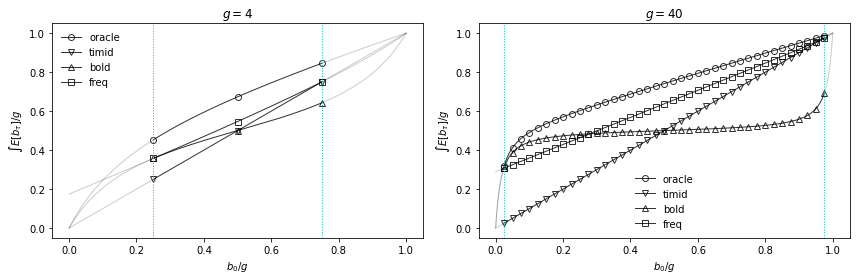

In [22]:
fig, ax = plt.subplots(1, arr_g_size, figsize=(12, 4))

for idx_g in range(arr_g_size): 
    g = g_base * arr_g_factor[idx_g]
    first = np.argmax(arr_ratio * g >= 1)
    last  = np.argmax(arr_ratio * g > g-1)
    #marks = None
    marks = np.flatnonzero(arr_ratio * g >= 1)[0] # and np.nozero(arr_ratio * g <= g-1) and np.nozero(arr_ratio // 1 == arr_ratio))[0][0]
    ax[idx_g].set_title(f'$g={g}$')

    ax[idx_g].plot(arr_ratio[:first],   theoretical_oracle_naive_score[idx_g][:first],       alpha=0.2, color='k', lw=1, linestyle='-')
    ax[idx_g].plot(arr_ratio[first:last], theoretical_oracle_naive_score[idx_g][first:last], alpha=0.8, color='k', lw=1, linestyle='-', marker='o', mfc='none', markevery=marks, label='oracle') # + f' ($u = {theoretical_oracle_naive_score[idx_b, idx_g]:.2}$)' )
    ax[idx_g].plot(arr_ratio[last:],    theoretical_oracle_naive_score[idx_g][last:],        alpha=0.2, color='k', lw=1, linestyle='-')

    ax[idx_g].plot(arr_ratio[:first],   theoretical_always_quit_score[idx_g][:first],        alpha=0.2, color='k', lw=1, linestyle='-')
    ax[idx_g].plot(arr_ratio[first:last], theoretical_always_quit_score[idx_g][first:last],  alpha=0.8, color='k', lw=1, linestyle='-', marker='v',  mfc='none', markevery=marks, label='timid') # + f' ($u = {theoretical_always_quit_score[idx_b, idx_g]:.2}$)' )
    ax[idx_g].plot(arr_ratio[last:],    theoretical_always_quit_score[idx_g][last:],         alpha=0.2, color='k', lw=1, linestyle='-')

    ax[idx_g].plot(arr_ratio[:first],   theoretical_always_play_score[idx_g][:first],        alpha=0.2, color='k', lw=1, linestyle='-')
    ax[idx_g].plot(arr_ratio[first:last], theoretical_always_play_score[idx_g][first:last],  alpha=0.8, color='k', lw=1, linestyle='-', marker='^',  mfc='none', markevery=marks, label='bold') # + f' ($u = {theoretical_always_play_score[idx_b, idx_g]:.2}$)' )
    ax[idx_g].plot(arr_ratio[last:],    theoretical_always_play_score[idx_g][last:],         alpha=0.2, color='k', lw=1, linestyle='-')

    #  ax[idx_g].plot(arr_ratio[:first],   theoretical_play_quit_score[idx_g][:first],          alpha=0.2, color='k', lw=1, linestyle='-')
    #  ax[idx_g].plot(arr_ratio[first:last], theoretical_play_quit_score[idx_g][first:last],    alpha=0.8, color='k', lw=1, linestyle='-',  marker='|',  mfc='none',  markevery=marks, label='potential') # + f' ($u = {theoretical_play_quit_score[idx_b, idx_g]:.2}$)' )
    #  ax[idx_g].plot(arr_ratio[last:],    theoretical_play_quit_score[idx_g][last:],           alpha=0.2, color='k', lw=1, linestyle='-')

    ax[idx_g].plot(arr_ratio[:first],   theoretical_freq_naive_score[idx_g][:first],         alpha=0.2, color='k', lw=1, linestyle='-')
    ax[idx_g].plot(arr_ratio[first:last], theoretical_freq_naive_score[idx_g][first:last],   alpha=0.8, color='k', lw=1, linestyle='-', marker='s',  mfc='none', markevery=marks, label='freq') # + f' ($u = {theoretical_freq_naive_score[idx_b, idx_g]:.2}$)' )
    ax[idx_g].plot(arr_ratio[last:],    theoretical_freq_naive_score[idx_g][last:],          alpha=0.2, color='k', lw=1, linestyle='-')

    ax[idx_g].legend(loc='best', frameon=False)
    ax[idx_g].set_xlabel('$b_0/g$')
    ax[idx_g].set_ylabel('$\int E[b_\\tau] / g$')
    ax[idx_g].axvline(x=1/g,      color='c', lw=1, linestyle=':')
    ax[idx_g].axvline(x=(g-1)/g, color='c', lw=1, linestyle=':')

#fig.suptitle('Number of possible paths from a given initial budget to achieve another budget level.')
fig.tight_layout()

plt.savefig('basic_strategies_utilities.pdf', bbox_inches='tight')

if COLAB:
    files.download('basic_strategies_utilities.pdf')

plt.show()

#print(arr_p)

In [23]:
import numpy as np
import networkx as nx

t_max = 30 #15
b_0_max = 8
b_max_max = (b_0_max + t_max) // 2

G = [nx.DiGraph() for k in range(b_0_max)]
pos = [{} for k in range(b_0_max)]

for k, b_0 in enumerate(range(1, b_0_max+1)):

  b_max = (b_0 + t_max) // 2

  up_steps = b_max - b_0
  dw_steps = t_max - up_steps

  for i in range(0, up_steps+1):
    for j in range(0, dw_steps+1):
      t = j + i
      b = b_0 + i - j
      if (b >= 0):
        G[k].add_node(f'({t},{b})', pos=(t,b))
        pos[k][f'({t},{b})'] = (t,b)
      if (i > 0) and (b > 1):
        G[k].add_edge(f'({t-1},{b-1})', f'({t},{b})', color='g', weight=2, style='solid')
      if (j > 0) and (b >= 0):
        G[k].add_edge(f'({t-1},{b+1})', f'({t},{b})', color='r', weight=2, style='dotted')

  node = f'({0},{b_0})'
  G[k].nodes[node]['catalan_value'] = 1
  G[k].nodes[node]['up_steps'] = 0
  G[k].nodes[node]['dw_steps'] = 0

  for t in range(1, t_max+1):
    for b in range(0, b_max+1):
      node = f'({t},{b})'
      if node in G[k]:
        G[k].nodes[node]['up_steps'] = ((t - (b - b_0)) // 2) + (b - b_0)
        upstr = str(G[k].nodes[node]['up_steps'])
        G[k].nodes[node]['dw_steps'] = t - G[k].nodes[node]['up_steps']
        dwstr = str(G[k].nodes[node]['dw_steps'])
        G[k].nodes[node]['p_hat'] = (G[k].nodes[node]['up_steps']+1)/(t+2)
        G[k].nodes[node]['hat_policy'] = '$\top$' if G[k].nodes[node]['p_hat'] >= 0.5 else '$\bot$'
        s = 0
        for pred in G[k].predecessors(node):
          s += G[k].nodes[pred]['catalan_value']
          G[k].nodes[node]['catalan_value'] = s

  edges = G[k].edges()
  colors = [G[k][u][v]['color'] for u,v in edges]
  weights = [G[k][u][v]['weight'] for u,v in edges]
  styles = [G[k][u][v]['style'] for u,v in edges]



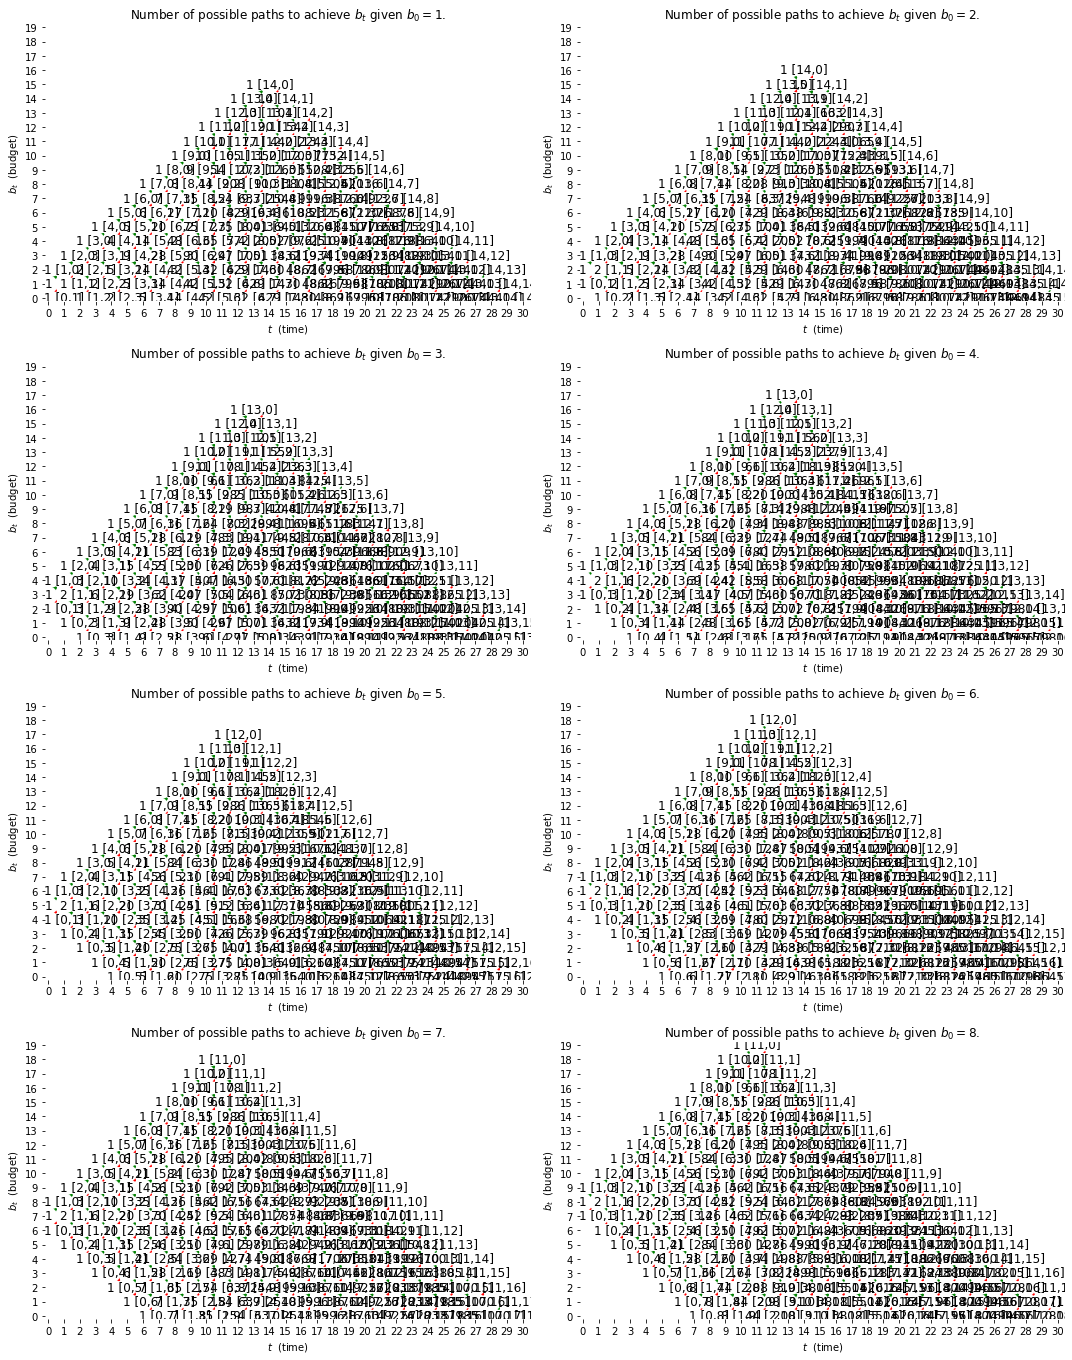

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(b_0_max//2, 2, figsize=(15,19))

for k, b_0 in enumerate(range(1, b_0_max+1)):

  k_y = k%2
  k_x = k//2


  # define node labels
  labels={}
  node = f'({0},{b_0})'
  labels[node] = '1'
  for t in range(1, t_max+1):
    for b in range(0, b_max+1):
      node = f'({t},{b})'
      if node in G[k]:
        for pred in G[k].predecessors(node):
          labels[node] = f'{G[k].nodes[node]["catalan_value"]} [{G[k].nodes[node]["up_steps"]},{G[k].nodes[node]["dw_steps"]}]'

  nx.draw_networkx_nodes(G[k], pos[k], labels, node_color='w', ax=ax[k_x][k_y])
  nx.draw_networkx_edges(G[k], pos[k], edge_color=colors, width=weights, ax=ax[k_x][k_y])  #style=styles
  nx.draw_networkx_labels(G[k], pos[k], labels, ax=ax[k_x][k_y]) #font_size=16

  ax[k_x][k_y].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

  ax[k_x][k_y].set_xticks(range(0, t_max+1))
  ax[k_x][k_y].set_yticks(range(0, b_max_max+1))

  ax[k_x][k_y].set_xlim(-0.2, t_max+0.5)
  ax[k_x][k_y].set_ylim(-0.2, b_max_max+0.2)

  ax[k_x][k_y].spines['top'].set_visible(False)
  ax[k_x][k_y].spines['right'].set_visible(False)
  ax[k_x][k_y].spines['bottom'].set_visible(False)
  ax[k_x][k_y].spines['left'].set_visible(False)

  ax[k_x][k_y].grid(which='both')
  ax[k_x][k_y].grid(which='minor', alpha=0.2)
  ax[k_x][k_y].grid(which='major', alpha=0.7)

  ax[k_x][k_y].set_xlabel('$t$  (time)')
  ax[k_x][k_y].set_ylabel('$b_t$  (budget)')
  ax[k_x][k_y].set_title(f'Number of possible paths to achieve $b_t$ given $b_0 = {b_0}$.')

#fig.suptitle('Number of possible paths from a given initial budget to achieve another budget level.')
fig.tight_layout()

#plt.savefig('combinations.pdf', bbox_inches='tight')
#files.download('combinations.pdf')

plt.show()


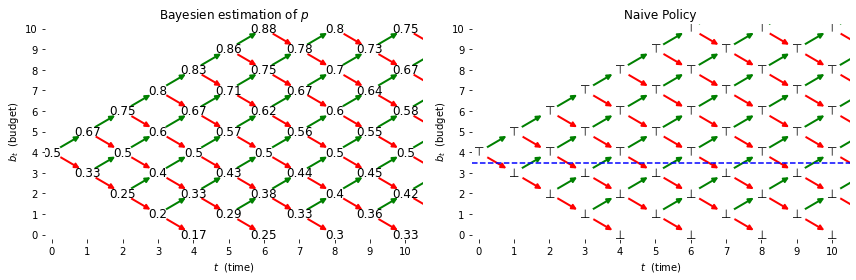

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12,4))

k=3
b_0=k+1

# define node labels
labels={}
node = f'({0},{b_0})'
labels[node] = '0.5'
for t in range(1, t_max+1):
  for b in range(0, b_max+1):
    node = f'({t},{b})'
    if node in G[k]:
      for pred in G[k].predecessors(node):
        #labels[node] = f'{G[k].nodes[node]["catalan_value"]} [{G[k].nodes[node]["up_steps"]},{G[k].nodes[node]["dw_steps"]}]'
        labels[node] = f'{G[k].nodes[node]["p_hat"]:.2}' #.lstrip('0')

nx.draw_networkx_nodes(G[k], pos[k], labels, node_color='w', ax=ax[0])
nx.draw_networkx_edges(G[k], pos[k], edge_color=colors, width=weights, ax=ax[0])   #style=styles,
nx.draw_networkx_labels(G[k], pos[k], labels, ax=ax[0]) #font_size=16

ax[0].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

ax[0].set_xticks(range(0, t_max+1))
ax[0].set_yticks(range(0, b_max_max+1))

ax[0].set_xlim(-0.2, 10+0.5)
ax[0].set_ylim(-0.2, 10+0.2)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['left'].set_visible(False)

ax[0].grid(which='both')
ax[0].grid(which='minor', alpha=0.2)
ax[0].grid(which='major', alpha=0.7)

ax[0].set_xlabel('$t$  (time)')
ax[0].set_ylabel('$b_t$  (budget)')
ax[0].set_title(f'Bayesien estimation of $p$')


# define node labels
labels={}
node = f'({0},{b_0})'
labels[node] = '$\\top$'
for t in range(1, t_max+1):
  for b in range(0, b_max+1):
    node = f'({t},{b})'
    if node in G[k]:
      for pred in G[k].predecessors(node):
        labels[node] = '$\\top$' if G[k].nodes[node]['p_hat'] >= 0.5 else '$\\bot$'

nx.draw_networkx_nodes(G[k], pos[k], labels, node_color='w', ax=ax[1])
nx.draw_networkx_edges(G[k], pos[k], edge_color=colors, width=weights, ax=ax[1])
nx.draw_networkx_labels(G[k], pos[k], labels, ax=ax[1]) #font_size=16

ax[1].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

ax[1].set_xticks(range(0, t_max+1))
ax[1].set_yticks(range(0, b_max_max+1))

ax[1].set_xlim(-0.2, 10+0.5)
ax[1].set_ylim(-0.2, 10+0.2)

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False)

ax[1].grid(which='both')
ax[1].grid(which='minor', alpha=0.2)
ax[1].grid(which='major', alpha=0.7)

ax[1].axhline(y=3.5, color='b', linestyle='--')

ax[1].set_xlabel('$t$  (time)')
ax[1].set_ylabel('$b_t$  (budget)')
ax[1].set_title('Naive Policy')


#fig.suptitle('Number of possible paths from a given initial budget to achieve another budget level.')
fig.tight_layout()

plt.savefig('naive_policy.pdf', bbox_inches='tight')

if COLAB:
    files.download('naive_policy.pdf')

plt.show()